# BindingAndCatalysis.jl minimal example

This notebook walks through the core API for binding networks:
- model construction from stoichiometry or conservation laws
- regime (vertex) enumeration and querying
- graph representations of regime transitions
- numerical mapping between qK and x spaces

> Tip: Most functions accept either a model and a vertex index/permutation or a `Vertex` object directly.


In [1]:
begin
    using Pkg
    dev_folder = @__DIR__
    Pkg.activate(dev_folder)
end

# ONLY run this block once to set up the development environment
# begin
#     pkg_folder = joinpath(dev_folder, "..")
#     Pkg.develop(path=pkg_folder)
#     Pkg.instantiate()
# end

Threads.nthreads()


  Activating project at `~/Realizibility_index/BindingAndCatalysis.jl/Examples`


24

In [2]:
# using Revise
using BindingAndCatalysis # import the package
using CairoMakie # for plotting, we use Makie backend, could also be GLMakie or WGLMakie...

[ Info: Precompiling BindingAndCatalysis [b532a4b1-2c45-4c12-bcaf-8695372aa40c] (cache misses: include_dependency fsize change (2), dep missing source (2))

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up
┌ Info: Skipping precompilation due to precompilable error. Importing BindingAndCatalysis [b532a4b1-2c45-4c12-bcaf-8695372aa40c].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notic

# Minimal example: binding networks

## Initialize the model

A binding network can be specified by either the stoichiometry matrix `N` or the conservation matrix `L`.
The package constructs the missing matrix so that `N * L' = 0`.

We recommend providing `N` so you can control the basis of atomic species.

Example network (monomer-dimer binding):

$$E + S \Longleftrightarrow C$$

with conservation laws:

$$tE = E + C$$
$$tS = S + C$$

and equilibrium:

$$E\,S = K\,C$$


In [3]:
model = let
    N = [1 1 -1]  # define stoichiometry matrix
    x_sym = [:E, :S, :C] # Optional: define species symbols
    q_sym = [:tE, :tS] # Optional: define total concentration symbols
    K_sym = [:K] # Optional: define binding constant symbols
    Bnc(N = N, x_sym=x_sym, q_sym=q_sym, K_sym=K_sym) # create Bnc model
end

----------Binding Network Summary:-------------
Number of species (n): 3
Number of conserved quantities (d): 2
Number of reactions (r): 1
L matrix: [1 0 1; 0 1 1]
N matrix: [1 1 -1]
Direction of binding reactions: backward
Catalysis involved: No
Regimes constructed: No
-----------------------------------------------

In [4]:
model.L  # get L matrix of model

2×3 Matrix{Int64}:
 1  0  1
 0  1  1

In [5]:
show_conservation(model)# display conservation relations, q=Lx

2-element Vector{Symbolics.Equation}:
 tE ~ C + E
 tS ~ C + S

In [6]:
show_equilibrium(model,log_space=true) |> display # display equilibrium concentrations in log space
show_equilibrium(model,log_space=false) # display equilibrium concentrations in linear space

1-element Vector{Symbolics.Equation}:
 log10(K) ~ log10(S) - log10(C) + log10(E)

1-element Vector{Symbolics.Equation}:
 K ~ (E*S) / C

In [7]:
logder_qK_x_sym(model) # get the symbolic log-derivative matrix of qK with respect to x
# equivalent to ∂logqK_∂logx_sym(model) 

3×3 Matrix{Symbolics.Num}:
 E / tE       0  C / tE
      0  S / tS  C / tS
      1       1      -1

In [8]:
# USE WITH CAUTION: simbolic invervse may be very slow for large models
logder_x_qK_sym(model) # get the symbolic log-derivative matrix of qK with respect to x
# equivalent to ∂logx_∂logqK_sym(model)

3×3 Matrix{Symbolics.Num}:
 (-C*tE - S*tE) / (-C*E - C*S - E*S)  …  (-C*S) / (-C*E - C*S - E*S)
         (C*tE) / (-C*E - C*S - E*S)     (-C*E) / (-C*E - C*S - E*S)
        (-S*tE) / (-C*E - C*S - E*S)      (E*S) / (-C*E - C*S - E*S)

In [9]:
x_sym(model) |> display # get species symbols
q_sym(model) |> display# get total concentration symbols
K_sym(model) |> display# get binding constant symbols
qK_sym(model) # get all symbols (q and K)

3-element Vector{Symbolics.Num}:
 E
 S
 C

2-element Vector{Symbolics.Num}:
 tE
 tS

1-element Vector{Symbolics.Num}:
 K

3-element Vector{Symbolics.Num}:
 tE
 tS
  K

In [10]:
summary(model) # display a summary of the model, currently we haven't find any regimes 

----------Binding Network Summary:-------------
Number of species (n): 3
Number of conserved quantities (d): 2
Number of reactions (r): 1
L matrix: [1 0 1; 0 1 1]
N matrix: [1 1 -1]
Direction of binding reactions: backward
Catalysis involved: No
Regimes constructed: No
-----------------------------------------------


## Regimes / vertices

A regime (vertex) is defined when each total $q_i$ is dominated by a single species $x_j$.
For example, $tS \approx S$ and $tE \approx E$ implies $S \gg C$ and $E \gg C$.

For each regime we store:
- Dominance map: $q = \tilde{P} x$ or $\log q = P \log x + P_0$
- Mapping $(q,K) \rightarrow x$: $\log x = H \log(q,K) + H_0$
- Mapping $x \rightarrow (q,K)$: $\log(q,K) = M \log x + M_0$
- $x$-space conditions: $C_x \log x + C_{0,x} \ge 0$
- $qK$-space conditions: $C_{qK} \log(q,K) + C_{0,qK} \ge 0$
- Volume: fraction of $qK$ space that satisfies the conditions


In [11]:
find_all_vertices!(model) # find all possible vertices

[ Info: ---------------------Start finding all vertices--------------------
[ Info: Finished, with 4 vertices found and 4 asymptotic vertices.
[ Info: -------------Start calculating nullity for each vertex, it also takes a while.------------
[ Info: 1.Building Nρ_inv cache in parallel...
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
[ Info: 2.Calculating nullity for each vertex in parallel...


4-element Vector{Vector{Int8}}:
 [1, 2]
 [1, 3]
 [3, 2]
 [3, 3]

In [12]:
get_vertices_perm_dict(model)# show the idx for all regimes' perm

Dict{Vector{Int8}, Int64} with 4 entries:
  [1, 3] => 2
  [3, 3] => 4
  [1, 2] => 1
  [3, 2] => 3

In [13]:
summary(model) # Now regime data is available


----------Binding Network Summary:-------------
Number of species (n): 3
Number of conserved quantities (d): 2
Number of reactions (r): 1
L matrix: [1 0 1; 0 1 1]
N matrix: [1 1 -1]
Direction of binding reactions: backward
Catalysis involved: No
Regimes constructed: Yes
Number of regimes: 4
  - Invertible + Asymptotic: 3
  - Singular +  Asymptotic: 1
  - Invertible +  Non-Asymptotic: 0
  - Singular +  Non-Asymptotic: 0
-----------------------------------------------


The regimes are classified as follows:

1. **Invertible vs. singular**
- Invertible: qK condition polyhedron is full dimension; `M` is invertible.
- Singular: qK condition polyhedron is lower dimensional; `M` is singular.

2. **Asymptotic vs. non-asymptotic**
- Asymptotic: the recession cone has the same dimension as the original polyhedron.
- Non-asymptotic: the recession cone has smaller dimension.


In [14]:
# To locate a regime, one  can model+ regime_idx/regime_perm
V1 = get_vertex(model,[1,2]) # fetch Vertex according to perm,
V2 = get_vertex(model,1) # fetch Vertex according to idx
V1 === V2

true

In [15]:
# when you have "Vertex", you can directly pass it as parameter without model
C₁, C0₁, nullity₁ = get_C_C0_nullity(V1)
C₂, C0₂, nullity₂ = get_C_C0_nullity(model,1)
C₃, C0₃, nullity_3 = get_C_C0_nullity(model,[1,2])
@assert C₁ == C₂ == C₃
@assert C0₁ == C0₂ == C0₃
@assert nullity₁ == nullity₂ == nullity_3

In [16]:
show_condition_x(V1)

2-element Vector{Symbolics.Num}:
 (-log10(C) + log10(E)) > 0
  (log10(S) - log10(C)) > 0

In [17]:
show_condition(model,[1,2];log_space=true) |> display
show_condition_qK(model,1;log_space=false) # show_condition is eqivalent to show_condition_qK

2-element Vector{Symbolics.Num}:
 (-log10(tS) + log10(K)) > 0
 (-log10(tE) + log10(K)) > 0

2-element Vector{Symbolics.Num}:
 K > tS
 K > tE

In [18]:
get_perm(V1)

2-element Vector{Int8}:
 1
 2

In [19]:
get_idx(model,[1,2])

1

In [20]:
get_nullity(model,1)

0

In [21]:
is_singular(V1)

false

In [22]:
is_asymptotic(model,1)

true

In [23]:
# Get properties of regimes
get_P_P0(model,[1,2]) # get P and P0
get_P(model,1)
get_P0(V1)

get_H_H0(model,1) # get H and H0
get_H(V1)
get_H0(model,[1,2])

# x space conditon 
get_C_C0_x(model,1)
get_C_x(model,[1,2])
get_C0_x(V1)

# qK space condition
get_C_C0_nullity(model,[1,2]) # equal to get_C_C0_nullity_qK
get_C_C0(model,1) # equal to get_C_C0
get_C0(V1) # equal to get_C0
get_C(V1) # equal to get_C

2×3 SparseArrays.SparseMatrixCSC{Float64, Int64} with 4 stored entries:
   ⋅   -1.0  1.0
 -1.0    ⋅   1.0

In [24]:
get_volume(model,1) # get volume of regime 1

[ Info: Number of polyhedra to calc volume: 1
[ Info: All regimes converged after 400000 samples.


BindingAndCatalysis.Volume(0.33195911380536125, 2.129703422591932e-6)

In [25]:
get_one_inner_point(model,2) # get one point that is sure to within specific regime

3-element Vector{Float64}:
  1.2844375263757621
 -2.0751444547981484
  0.1848260945119556

In [26]:
poly = get_polyhedron(model,[1,2]) # get polyhedron denotes qK condition, backend using Polyhedra.jl and CDDLib.jl

# get_polyhedron(C,C0,nullity) is also valid

Polyhedron CDDLib.Polyhedron{Float64}:
2-element iterator of Polyhedra.HalfSpace{Float64, Vector{Float64}}:
 HalfSpace([-0.0, 1.0, -1.0], 0.0)
 HalfSpace([1.0, -0.0, -1.0], 0.0)

In [27]:
# For polyheron we could also directly get C, C0 and nullity 

get_C_C0_nullity(poly) # express polyhedra as Cx+C0 >=0
get_C_C0(poly)
get_C0(poly)
get_C(poly)

get_nullity(poly)

0

In [28]:
get_one_inner_point(poly)

3-element Vector{Float64}:
 -2.7944568763769175
 -2.9118973210205064
 -0.3460058878908582

In [29]:
calc_volume(poly) |> display

[ Info: Number of polyhedra to calc volume: 1
[ Info: All regimes converged after 400000 samples.


"Volume(mean=3.317e-01, var=2.129e-06, rel_error=0.44%)"

In [30]:
summary(V1)

idx=1,perm=Int8[1, 2], asymptotic=true, nullity=0
volume=0.33195911380536125 +- 0.0014593503426497464
Dominante condition


tE ~ E

tS ~ S

x expression


E ~ tE

S ~ tS

C ~ (tE*tS) / K

condition:


K > tS

K > tE

In [31]:
get_volumes(model) # compute volumes for all regimes

get_volumes(model, [[1,3],[3,2]]) # compute volumes for two regimes


[ Info: Number of polyhedra to calc volume: 2
[ Info: All regimes converged after 400000 samples.


2-element Vector{BindingAndCatalysis.Volume}:
 BindingAndCatalysis.Volume(0.334499089412332, 2.137839517396728e-6)
 BindingAndCatalysis.Volume(0.3328641051141441, 2.132616516768021e-6)

### Query regimes by specific properties


In [32]:
get_vertices(model; singular=true, return_idx=true)

1-element Vector{Int64}:
 4

## Check regime feasibility with additional constraints


In [33]:
 # for example, we need tE>=2*tS, 
#  which is equivalent to (logtE - log tS)+ (- log 2) >= 0
C_add = [1 -1 0] # add extra constraint C_add * x + C0_add >=0
C0_add = [-log10(2)]

# check if regime 1 is feasible with the extra constraint
check_feasibility_with_constraint(model,4; C= C_add,C0= C0_add)

[ Info: The dimension of the intersected polyhedra is 0


false

In [34]:
# get all feasible vertices with the extra constraint
feasible_vertieces_with_constraint(model; C= C_add,C0= C0_add, return_idx=true)

[ Info: The dimension of the intersected polyhedra is 3
[ Info: The dimension of the intersected polyhedra is 3
[ Info: The dimension of the intersected polyhedra is 0
[ Info: The dimension of the intersected polyhedra is 0


2-element Vector{Int64}:
 1
 2

## Regime graph


### Build the regime graph


In [35]:
vtx_grh = get_vertices_graph!(model, full=true)

[ Info: Start calculating vertices neighbor graph, It may takes a while.
[ Info: Calculating vertices neighbor graph with qK change dir
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


BindingAndCatalysis.VertexGraph{Int8}(Bnc{Int8}([1 1 -1], [1 0 1; 0 1 1], 1, 3, 2, Symbolics.Num[E, S, C], Symbolics.Num[tE, tS], Symbolics.Num[K], nothing, Vector{Int8}[[1, 2], [1, 3], [3, 2], [3, 3]], Dict{Vector{Int8}, Int64}([1, 3] => 2, [3, 3] => 4, [1, 2] => 1, [3, 2] => 3), Bool[1, 1, 1, 1], Int8[0, 0, 0, 1], BindingAndCatalysis.VertexGraph{Int8}(#= circular reference @-2 =#), BindingAndCatalysis.Vertex[BindingAndCatalysis.Vertex{Float64, Int8}(Bnc{Int8}(#= circular reference @-3 =#), Int8[1, 2], 1, true, sparse([1, 2], [1, 2], [1, 1], 2, 3), [0.0, 0.0], sparse([1, 3, 2, 3, 3], [1, 1, 2, 2, 3], [1, 1, 1, 1, -1], 3, 3), [0.0, 0.0, 0.0], sparse([1, 2, 1, 2], [1, 2, 3, 3], [1, 1, -1, -1], 2, 3), [0.0, 0.0], 0, sparse([1, 3, 2, 3, 3], [1, 1, 2, 2, 3], [1.0, 1.0, 1.0, 1.0, -1.0], 3, 3), [0.0, 0.0, 0.0], sparse([2, 1, 1, 2], [1, 2, 3, 3], [-1.0, -1.0, 1.0, 1.0], 2, 3), [0.0, 0.0], BindingAndCatalysis.Volume(0.33195911380536125, 2.129703422591932e-6)), BindingAndCatalysis.Vertex{Float6

We can visualize the regime graph:


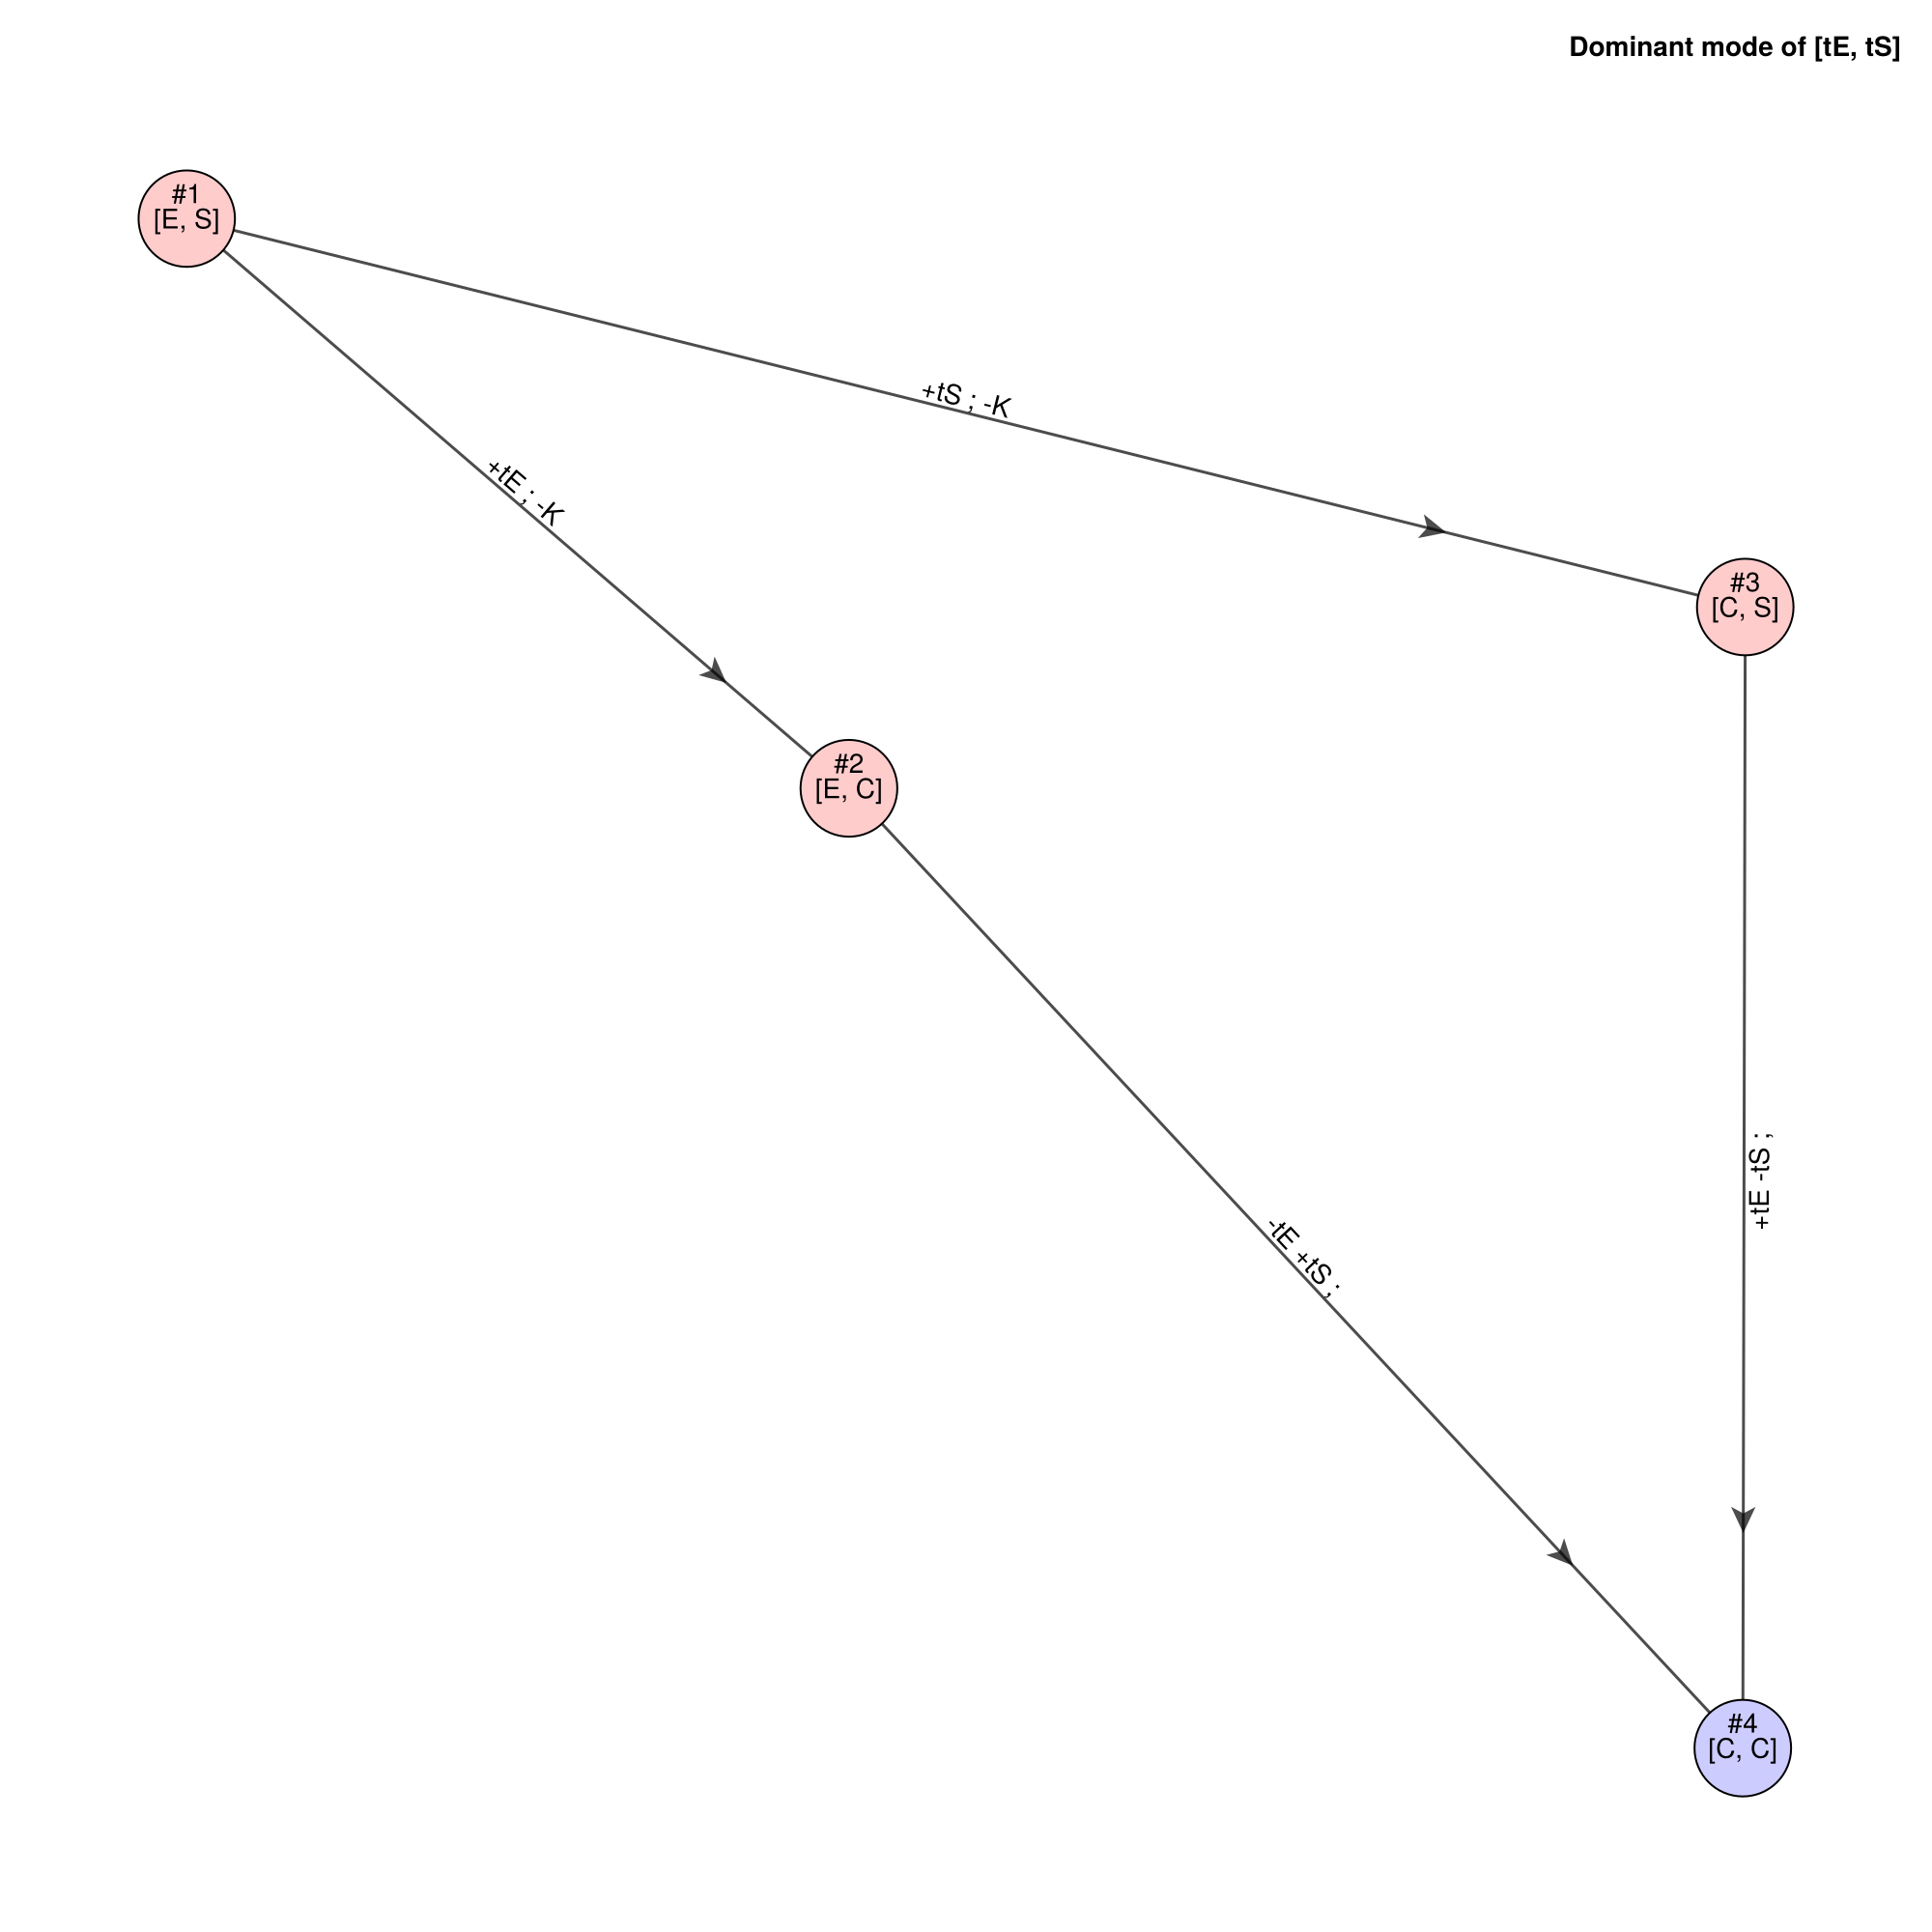

CairoMakie.Screen{IMAGE}


In [36]:
f,ax,p = draw_graph(vtx_grh) # draw the graph with custom node positions
display(f)

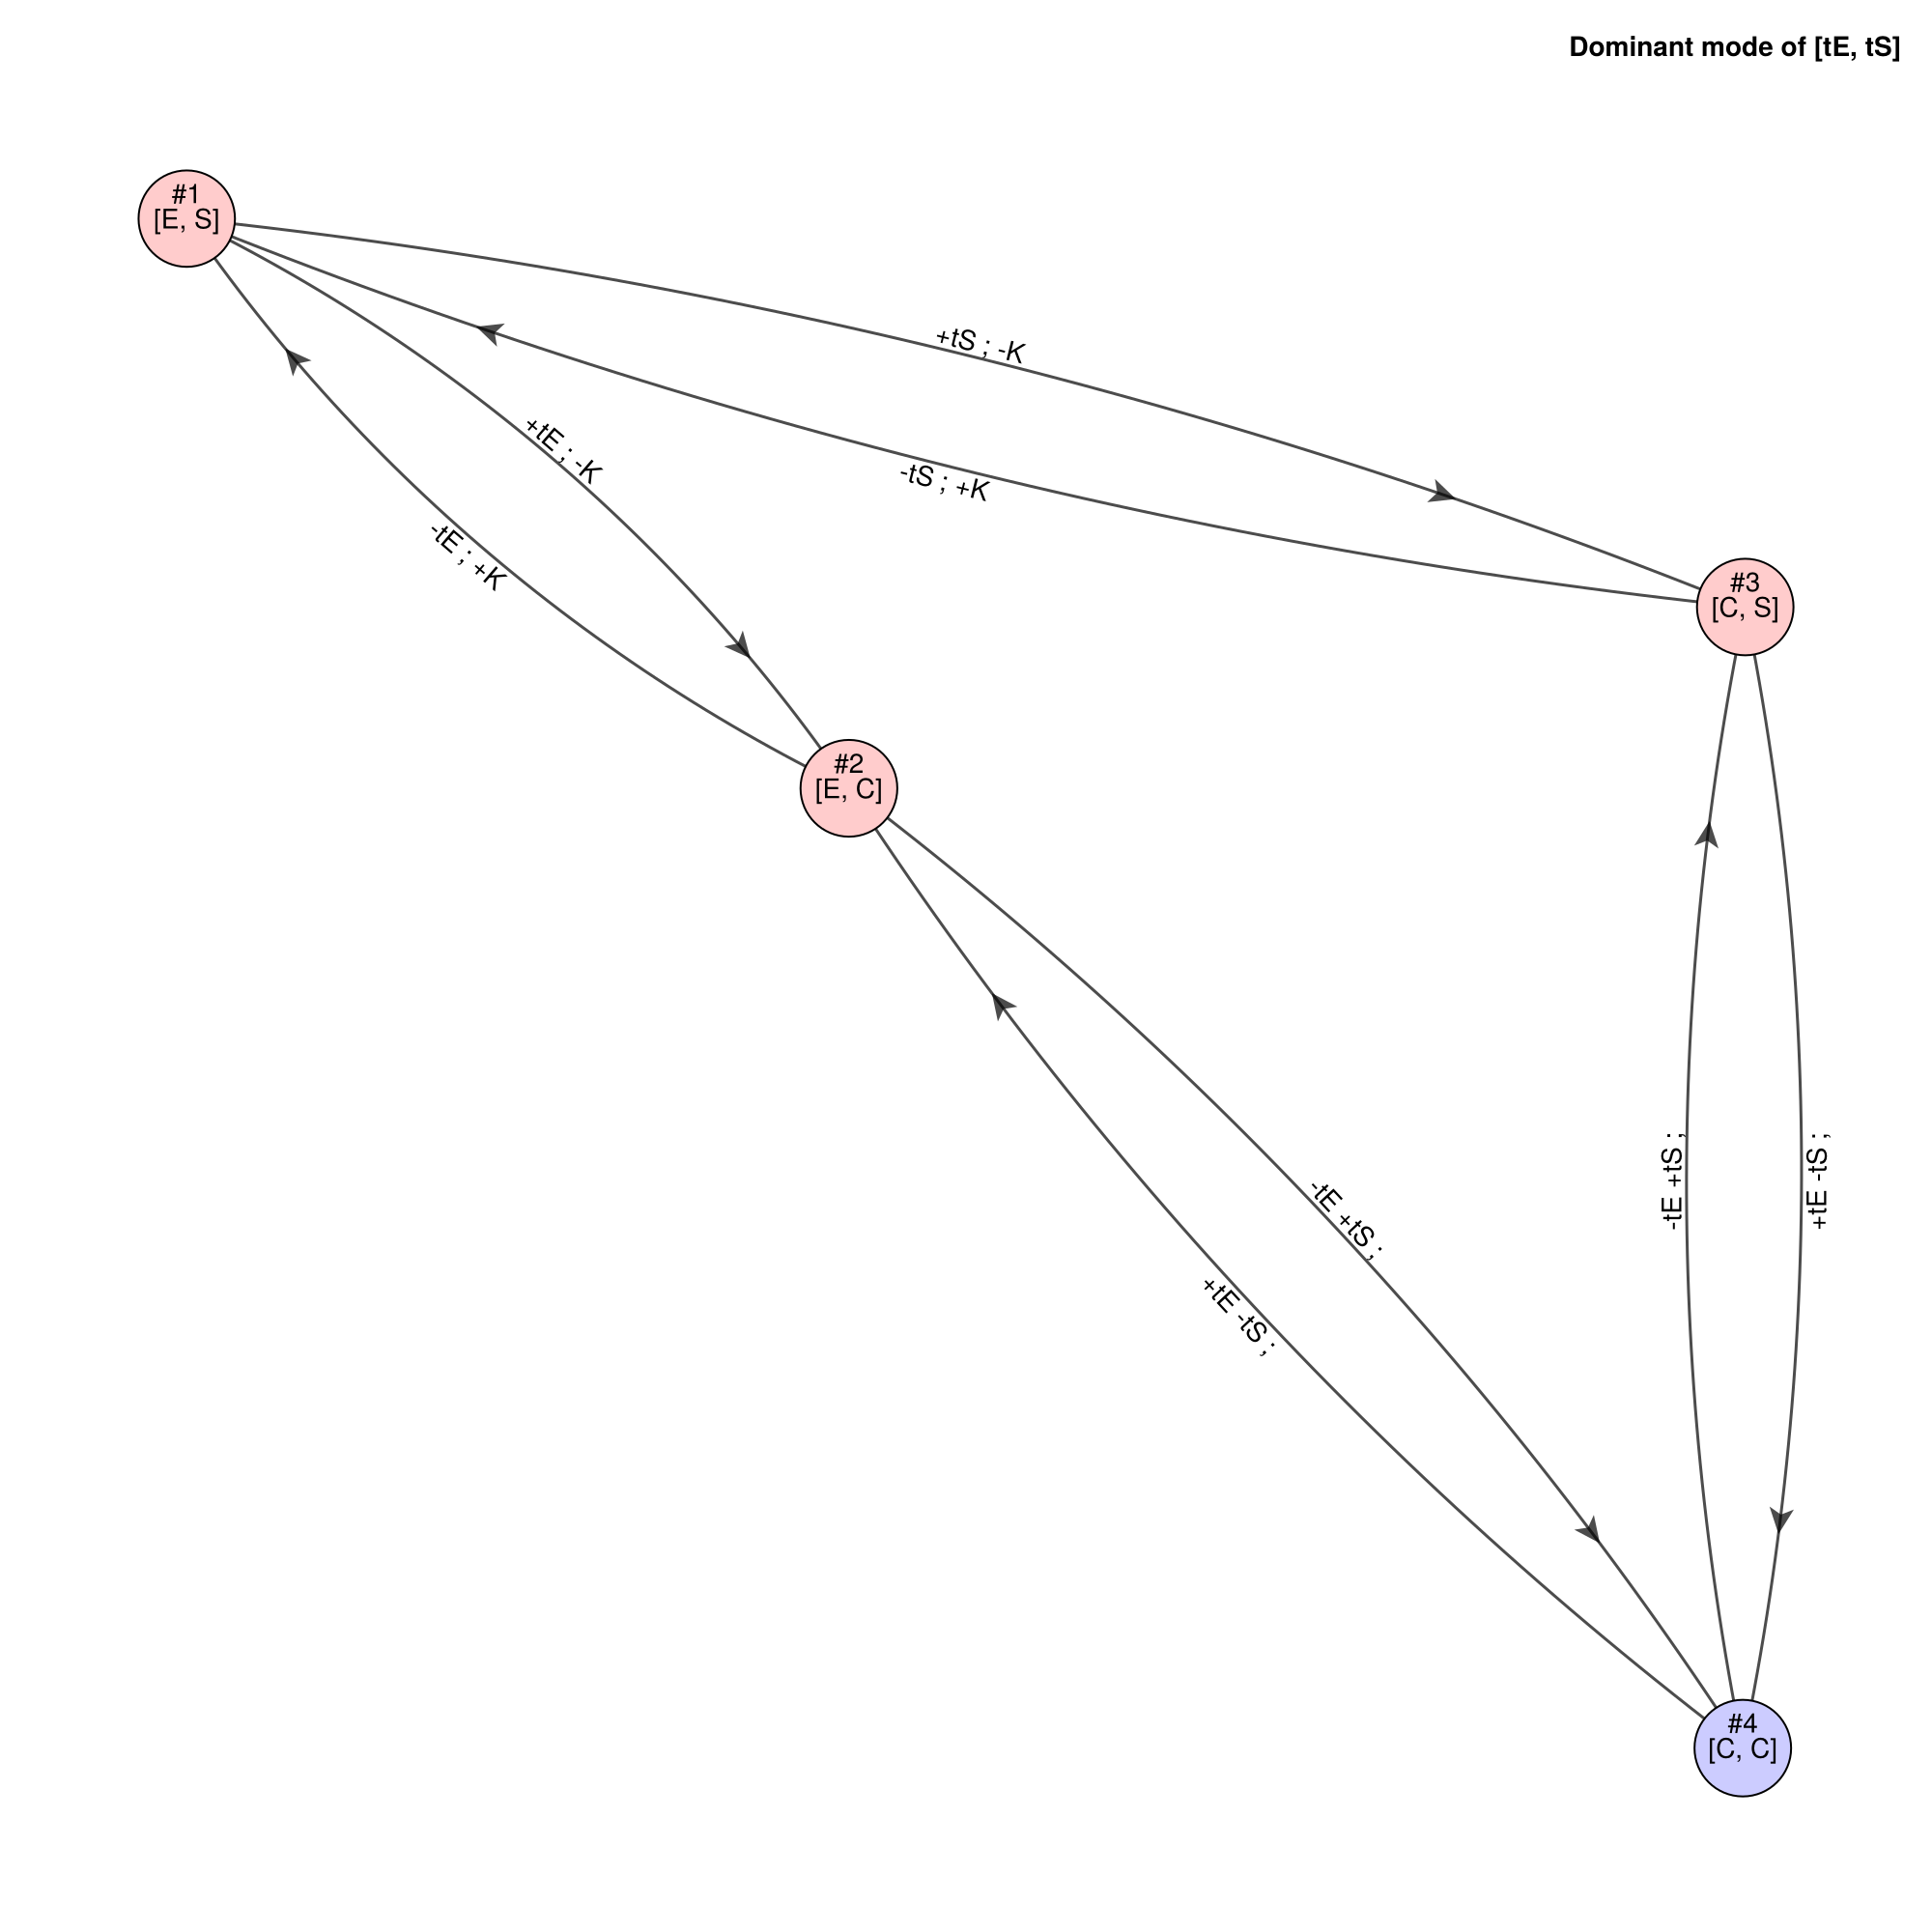

CairoMakie.Screen{IMAGE}


In [37]:
# both side edge
grh = get_neighbor_graph_qK(model; both_side=true) # SimpleDiGraph

f,ax,p = draw_graph(model, grh)
display(f)

Let's make the plot more detailed:


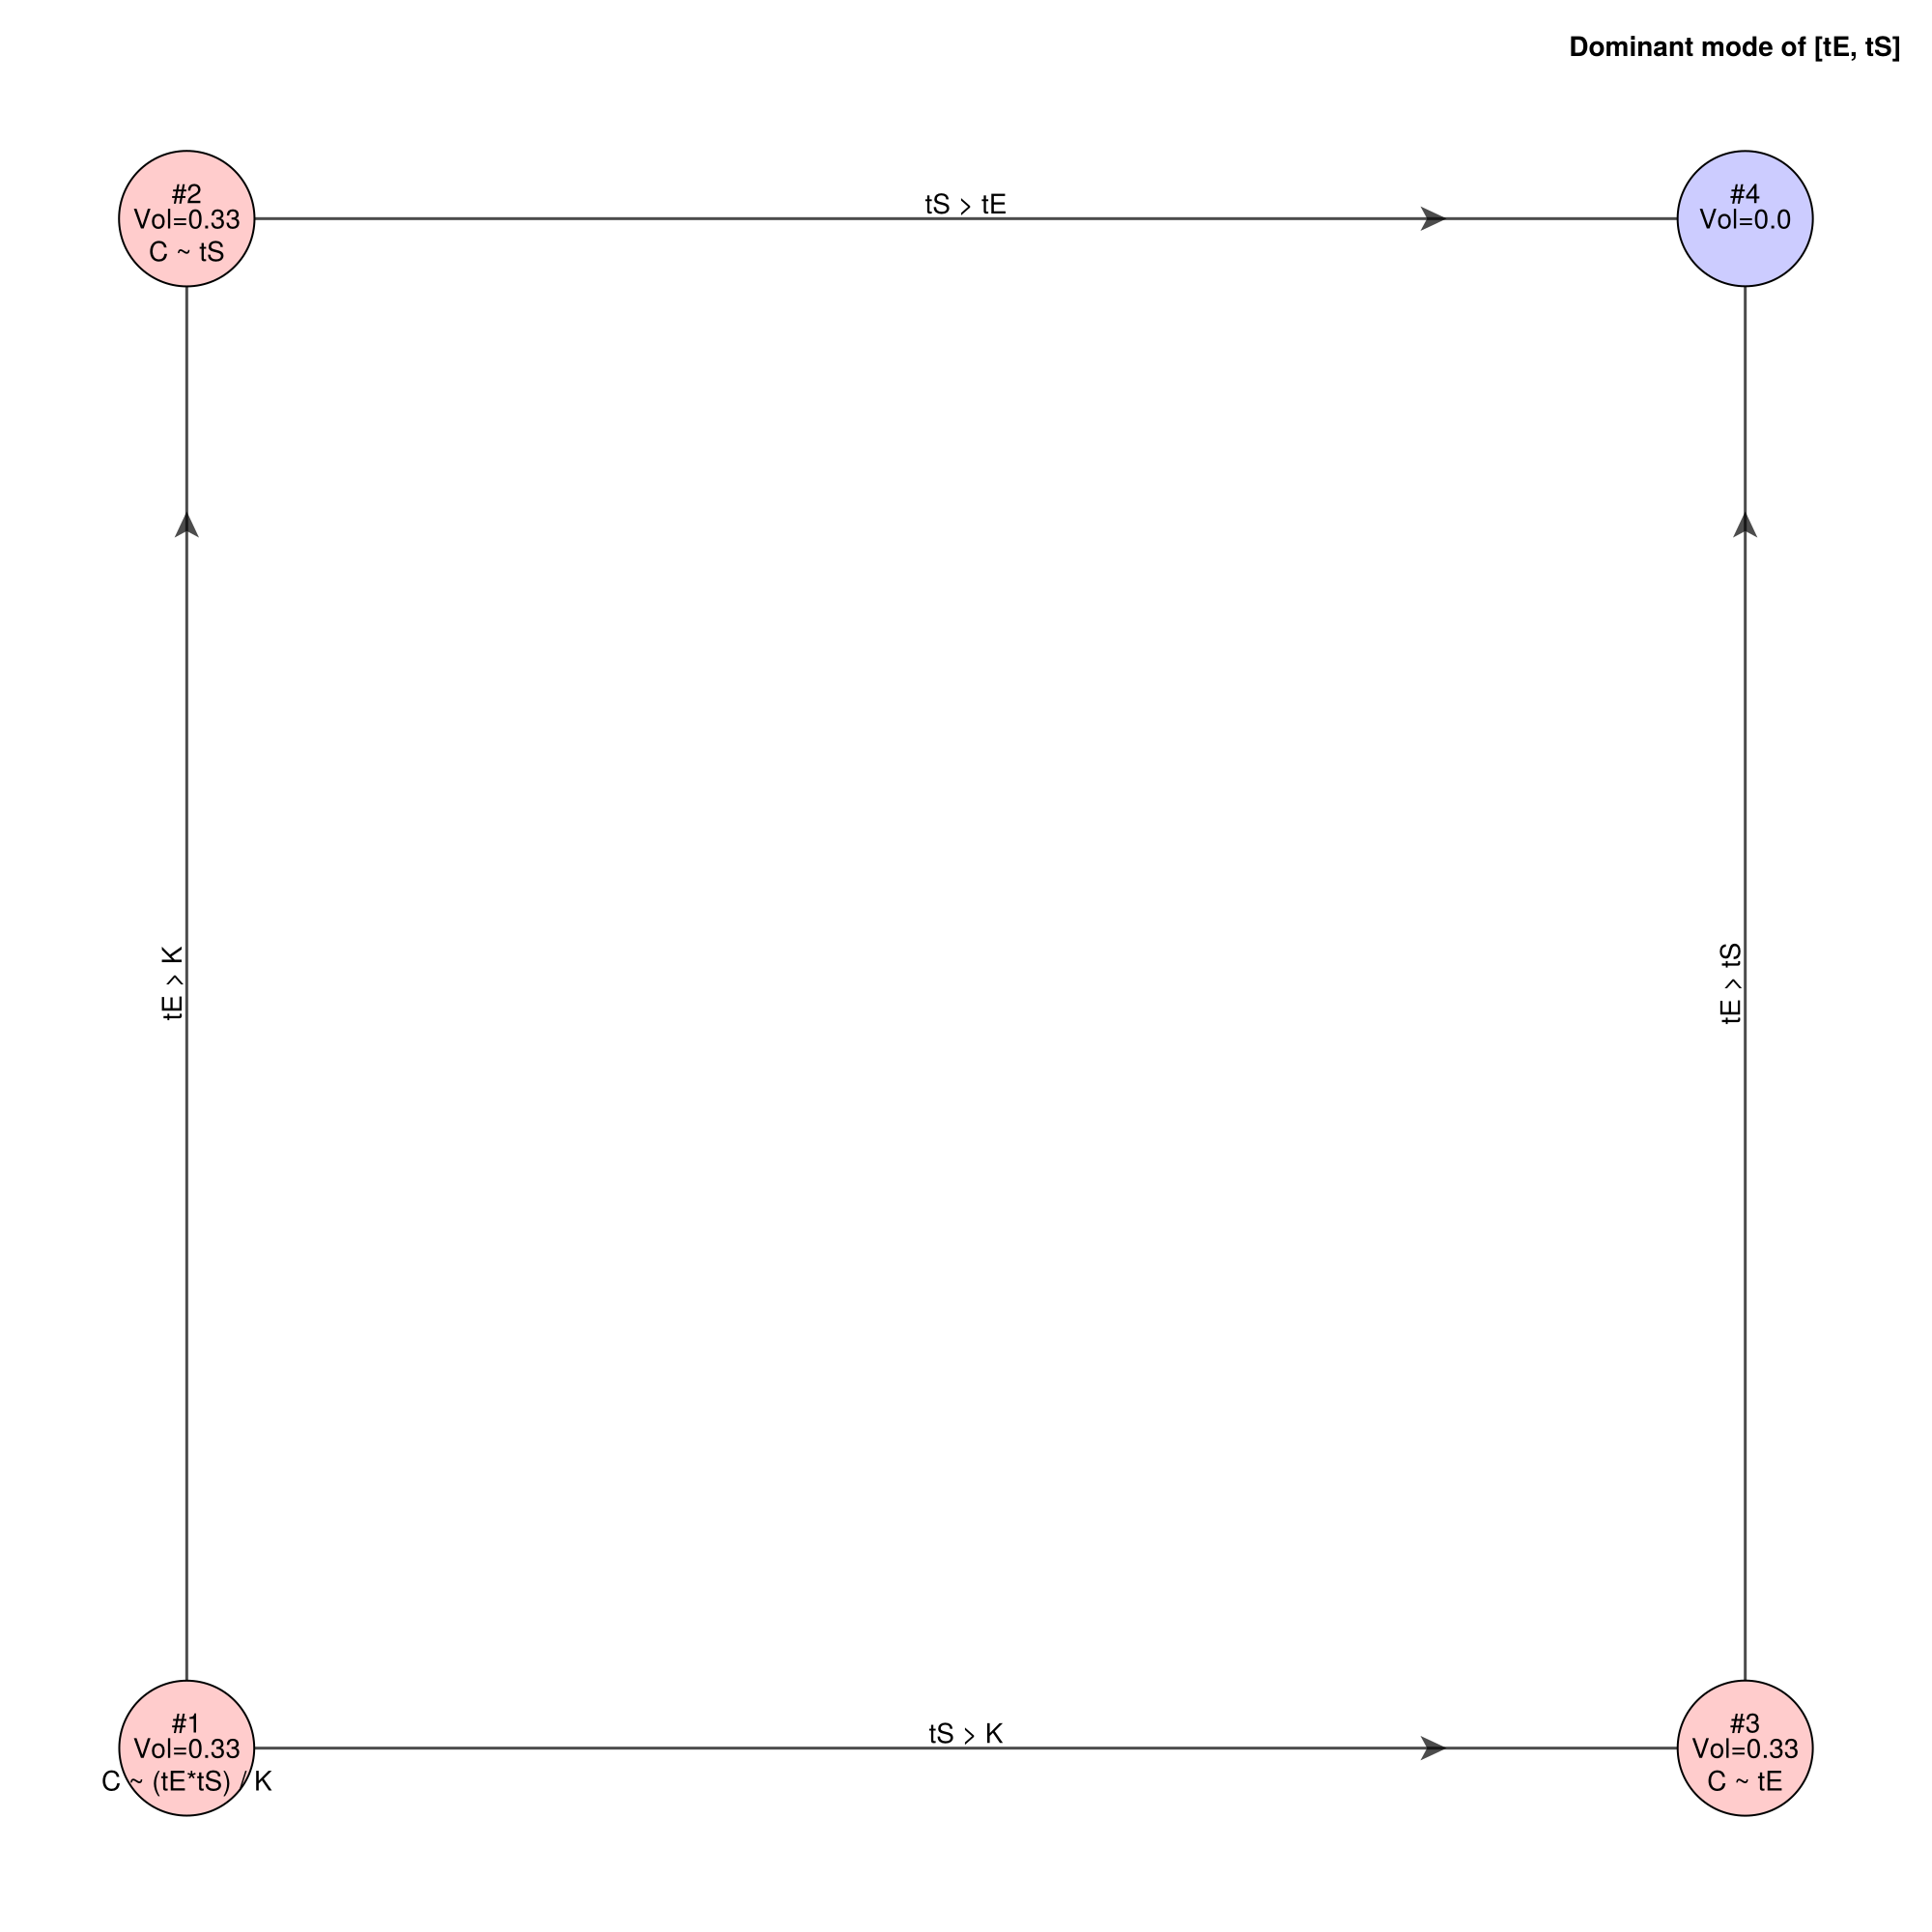

CairoMakie.Screen{IMAGE}


In [38]:
rgm_vol = get_volumes(model) .|> x->round(x.mean;digits=2) |> x->"Vol="*repr(x)

nodes_txt = let 
    n = n_vertices(model)
    expr = Vector{Any}(undef,n)
    for i in 1:n
        expr[i] = is_singular(model,i) ? "" : show_expression_x(model,i; log_space=false)[3]
    end
    expr
end

# define function of how to get edge labels
edge_func(from, to) = show_interface(model,from,to, log_space=false) |> x-> (x.lhs > x.rhs) |> string
interface_expr  = get_edge_labels(model, f=edge_func)


f,ax,p = draw_graph(model;
    node_posi=[[0,0], [0,1], [1,0], [1,1]],
    default_node_size= 70,
    node_labels= rgm_vol, 
    edge_labels=interface_expr,
    )

add_nodes_text!(ax,p, string.(nodes_txt); offset=(0,-25))
display(f)

When we have a regime path, we can check if two regimes are neighbors and inspect the interface
that encodes what $q,K$ changes move the system from one regime to another.


In [39]:
typeof(vtx_grh) # get the type of vertices graph, which is a LightGraphs.SimpleGraph

BindingAndCatalysis.VertexGraph{Int8}

In [40]:
p1 = [1,3]
p2 = [1,2]

get_edge(vtx_grh, p1, p2) # get the edge between regime 1 and 2, which is a polyhedron in qK space
# get_edge(model, p1, p2) #equivalent.

BindingAndCatalysis.VertexEdge{Int8}(1, 2, sparsevec(Int8[2, 3], Int8[1, -1], 3), 0.0, sparsevec(Int8[1, 3], [-1.0, 1.0], 3), 0.0)

In [41]:
get_intersect(model, p1, p2) # get the intersection between regime 1 and 2, which is a polyhedron in qK space

Polyhedron CDDLib.Polyhedron{Float64}:
1-element iterator of Polyhedra.HyperPlane{Float64, Vector{Float64}}:
 HyperPlane([-1.0, -0.0, 1.0], 0.0),
2-element iterator of Polyhedra.HalfSpace{Float64, Vector{Float64}}:
 HalfSpace([-1.0, 1.0, -0.0], 0.0)
 HalfSpace([-0.0, 1.0, -1.0], 0.0)

In [42]:
get_interface(model,p1,p2) # get the interface between regime 1 and 2

(sparsevec([1, 3], [-1.0, 1.0], 3), 0.0)

In [43]:
get_change_dir(model,p1,p2) |> x-> BindingAndCatalysis.sym_direction(model,x)

"-tE ; +K "

In [44]:
show_interface(model,p1,p2)

-log10(tE) + log10(K) ~ 0

When two regimes differ by more than one permutation entry, they are not neighbors in $x$ space.
In that case, we check adjacency in $qK$ space by intersecting their polyhedra.


In [45]:
p1 = [1,3]
p2 = [3,2]


get_edge(vtx_grh, p1, p2) === nothing # regime 1 and 3 are not direct adjacent, so no direct edge between them

true

In [46]:
get_intersect(model, p1, p2) # get the intersection of regime 1 and 2, which is a polyhedron in qK space

Polyhedron CDDLib.Polyhedron{Float64}:
1-element iterator of Polyhedra.HyperPlane{Float64, Vector{Float64}}:
 HyperPlane([-1.0, 1.0, -0.0], 0.0),
2-element iterator of Polyhedra.HalfSpace{Float64, Vector{Float64}}:
 HalfSpace([-1.0, -0.0, 1.0], 0.0)
 HalfSpace([-0.0, -1.0, 1.0], 0.0)

In [47]:
get_interface(model,p1,p2)

[ Info: no directly edge found, judge using Polyhedra.jl, could be problematic if you concerning changing direction


(sparsevec([1, 2], [-1.0, 1.0], 3), -0.0)

In [48]:
show_interface(model,p1,p2; log_space=false) # show the interface between regime 1 and 2, which is a polyhedron in qK space

[ Info: no directly edge found, judge using Polyhedra.jl, could be problematic if you concerning changing direction


tS ~ tE

In [49]:
show_interface(model,p1,p2;log_space=false, lhs_idx=1) # show the interface between regime 1 and 2, 
# Also let the E to be the only variable on lhs


[ Info: no directly edge found, judge using Polyhedra.jl, could be problematic if you concerning changing direction


tE ~ tS

If we only allow one $q$ or $K$ to change, we can draw a SISO (single-input/single-output) subgraph.


In [50]:
siso = get_SISO_graph(model, :tS) # will give you a simple DiGraph

{4, 3} directed simple Int64 graph

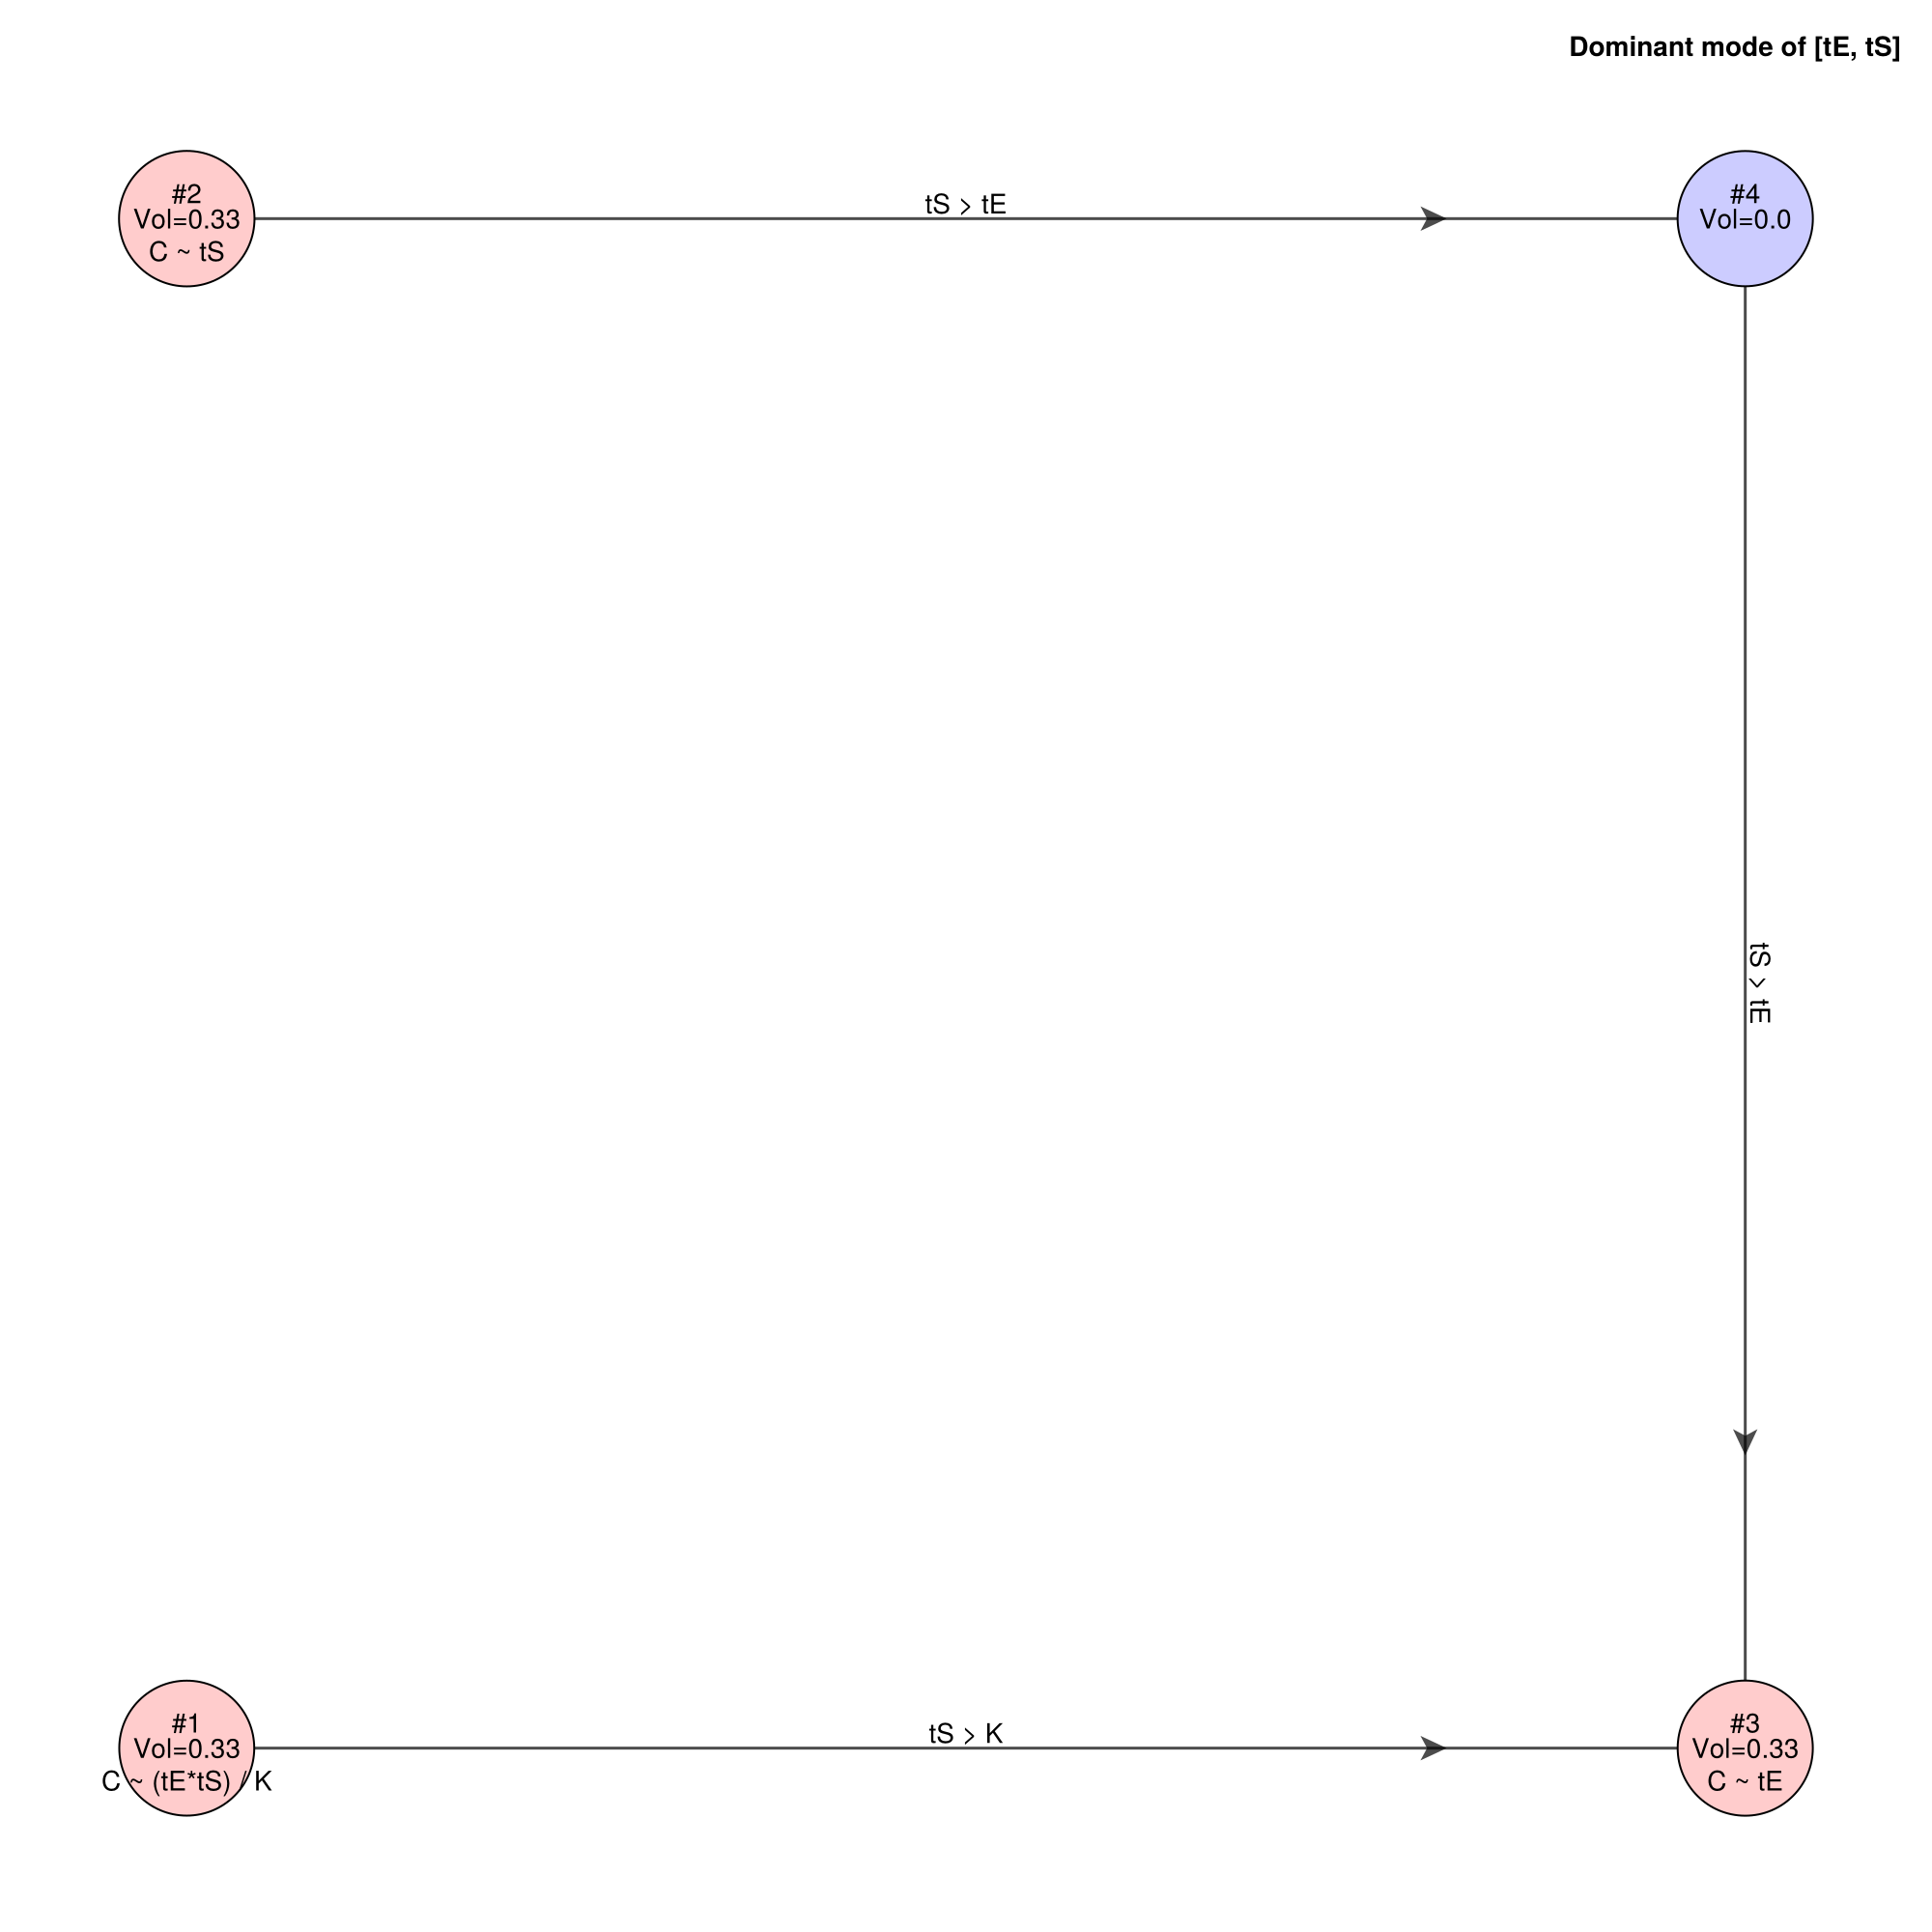

CairoMakie.Screen{IMAGE}


In [51]:
# we could apply to same draw function just by denote the graph
f,ax,p = draw_graph(model, siso; 
    node_posi=[[0,0], [0,1], [1,0], [1,1]],
    default_node_size= 70,
    node_labels= rgm_vol, 
    edge_labels=interface_expr,
    )
add_nodes_text!(ax,p, string.(nodes_txt); offset=(0,-25))
display(f)

Based on that, we create a SISOPaths object to encode the SISO paths 

In [52]:
pths = SISOPaths(model, :tS) # get all SISO paths for tS

[ Info: sources: [2, 1]
[ Info: sinks: [3]
[ Info: Start enumerating paths from sources to sinks. This may take a while if there are many paths.
[ Info: Total vertices to process in topological order: 4
[ Info: Finished enumerating paths. Now collecting paths from sources. Total sources: 2


SISOPaths{Int8}(Bnc{Int8}([1 1 -1], [1 0 1; 0 1 1], 1, 3, 2, Symbolics.Num[E, S, C], Symbolics.Num[tE, tS], Symbolics.Num[K], nothing, Vector{Int8}[[1, 2], [1, 3], [3, 2], [3, 3]], Dict{Vector{Int8}, Int64}([1, 3] => 2, [3, 3] => 4, [1, 2] => 1, [3, 2] => 3), Bool[1, 1, 1, 1], Int8[0, 0, 0, 1], BindingAndCatalysis.VertexGraph{Int8}(Bnc{Int8}(#= circular reference @-2 =#), Graphs.SimpleGraphs.SimpleGraph{Int64}(4, [[2, 3], [1, 4], [1, 4], [2, 3]]), Vector{BindingAndCatalysis.VertexEdge{Int8}}[[BindingAndCatalysis.VertexEdge{Int8}(3, 1, sparsevec(Int8[1, 3], Int8[-1, 1], 3), -0.0, sparsevec(Int8[2, 3], [1.0, -1.0], 3), 0.0), BindingAndCatalysis.VertexEdge{Int8}(2, 2, sparsevec(Int8[2, 3], Int8[-1, 1], 3), -0.0, sparsevec(Int8[1, 3], [1.0, -1.0], 3), 0.0)], [BindingAndCatalysis.VertexEdge{Int8}(1, 2, sparsevec(Int8[2, 3], Int8[1, -1], 3), 0.0, sparsevec(Int8[1, 3], [-1.0, 1.0], 3), 0.0), BindingAndCatalysis.VertexEdge{Int8}(4, 1, sparsevec(Int8[1, 3], Int8[-1, 1], 3), -0.0, sparsevec(Int8

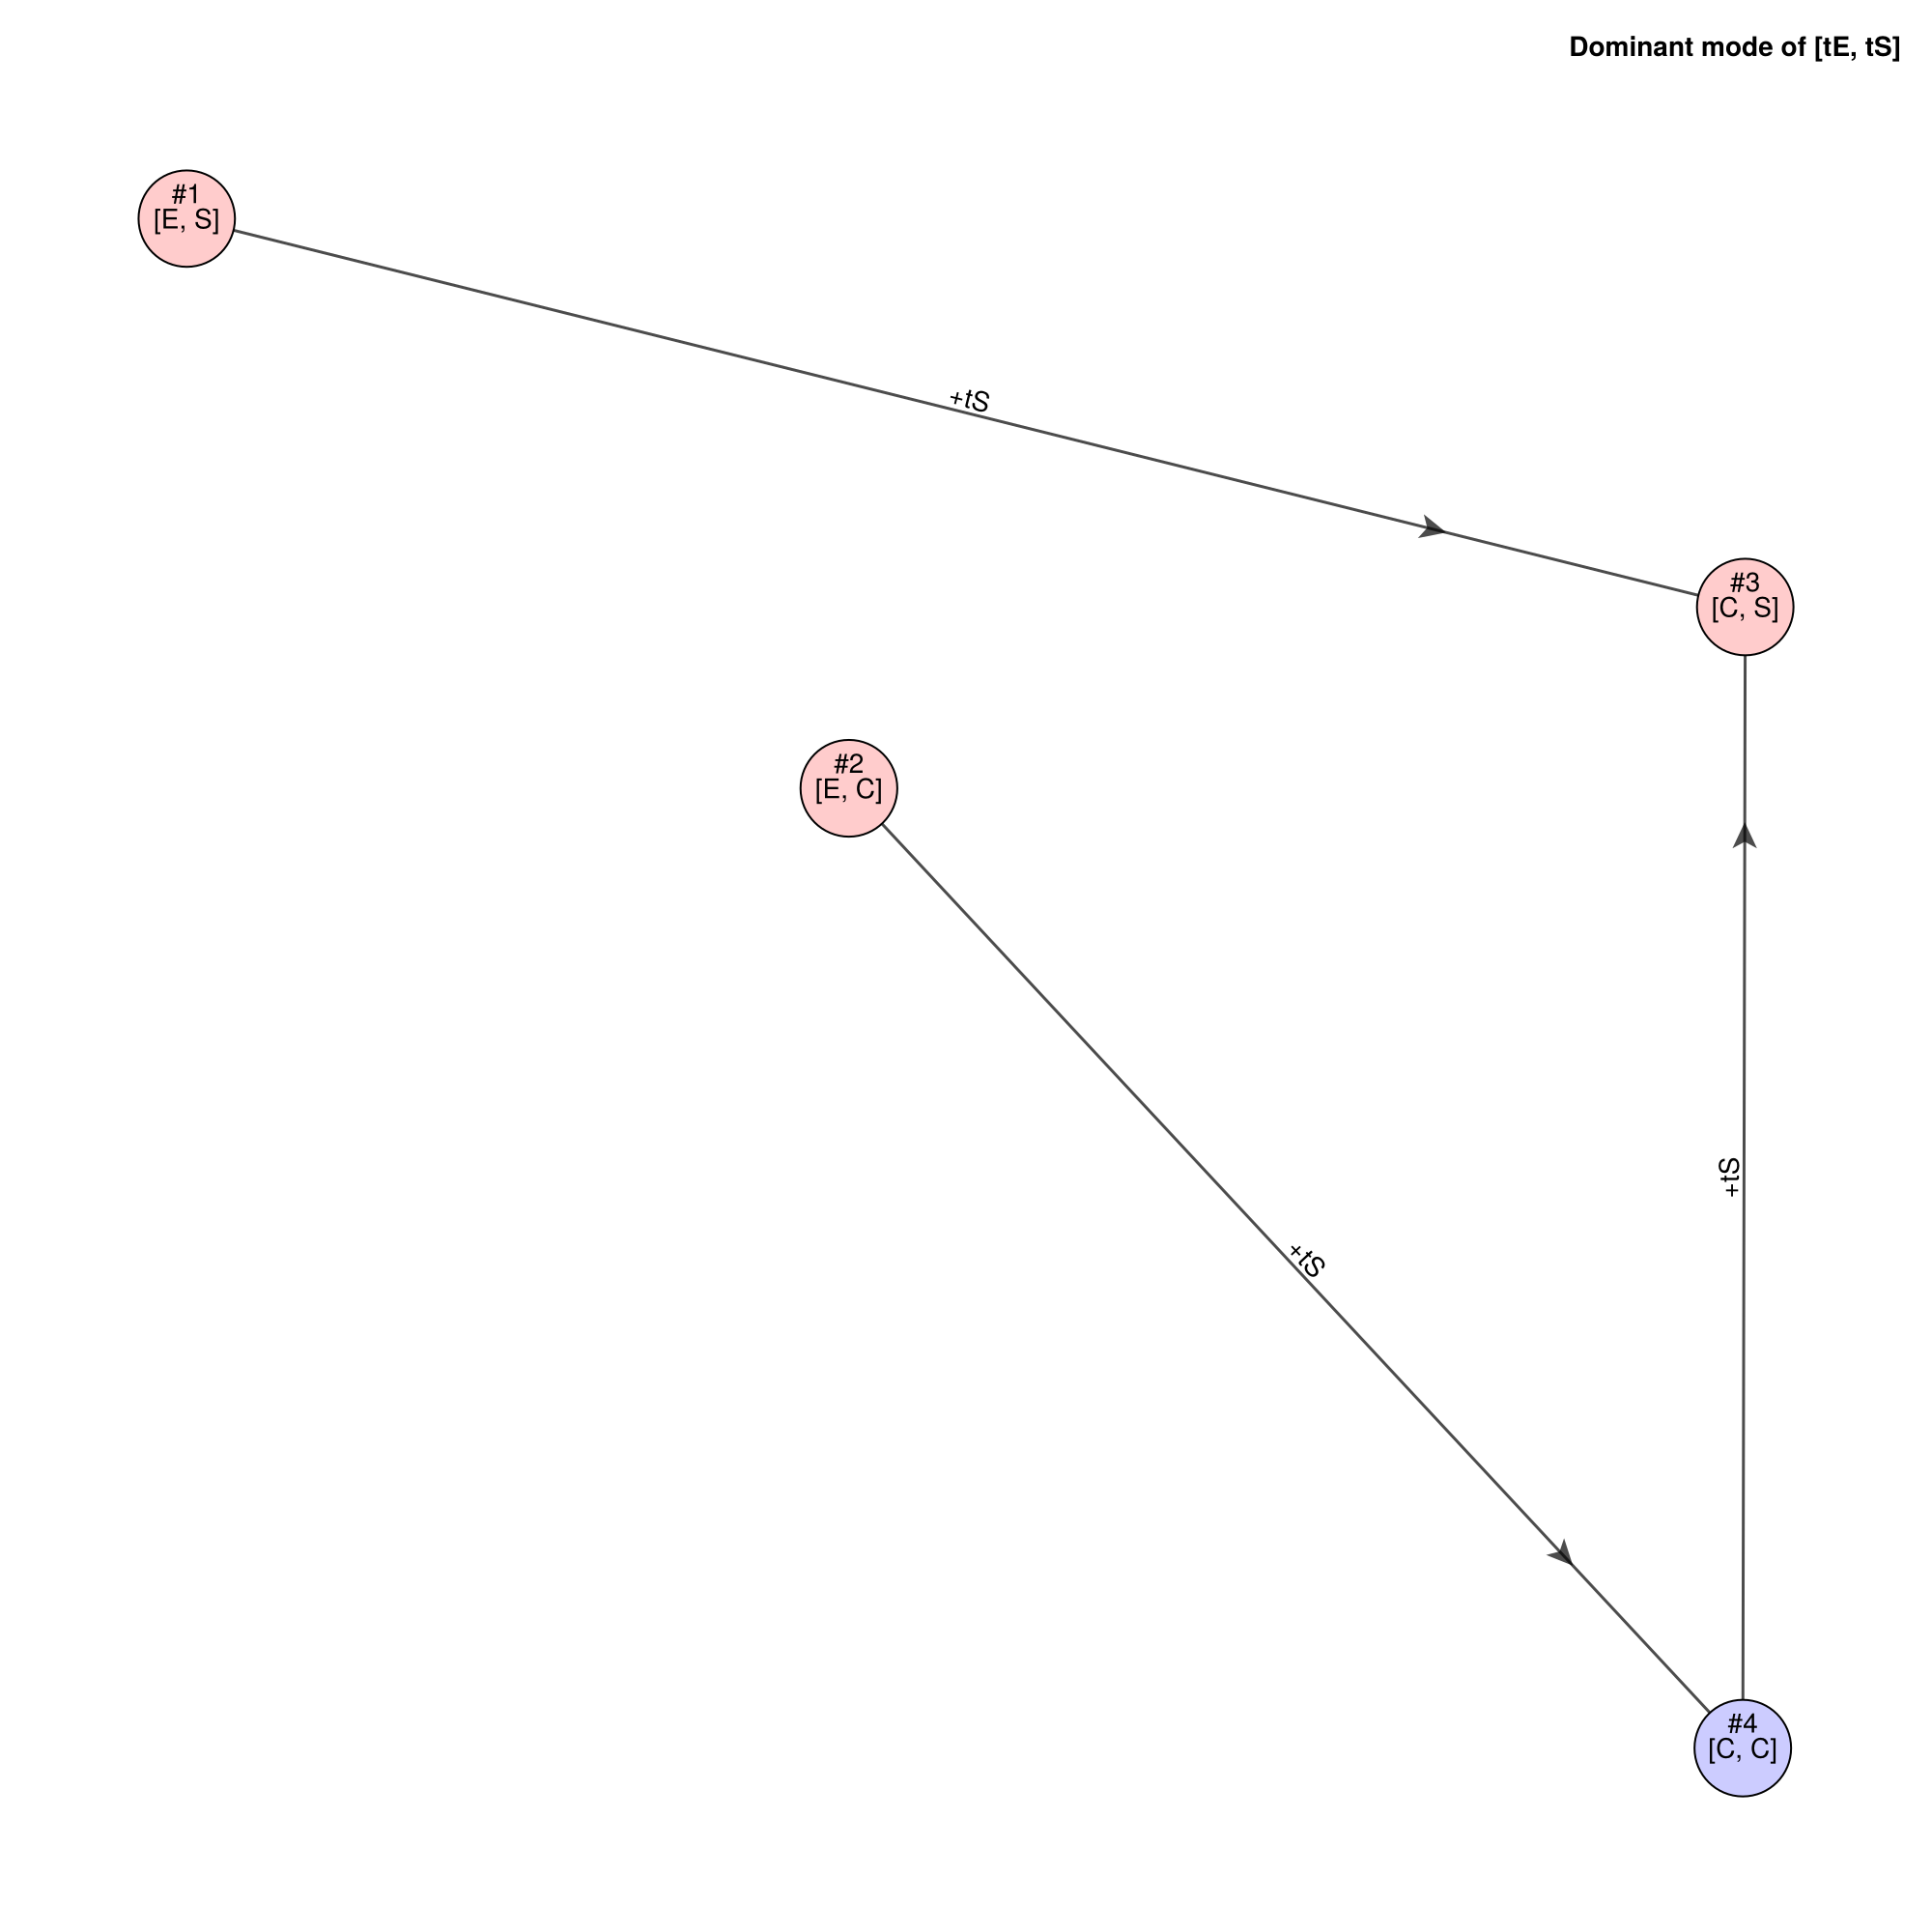

CairoMakie.Screen{IMAGE}


In [53]:
# you can pass SISOPaths directly to draw function, which is equivalent to draw_graph(model, get_SISO_graph(model, :tS))
f,ax,p = draw_graph(pths)
display(f)

In [54]:
# enumerate all SISO paths for increasing tS, note if set show_volume=true, 
# a lot of time will be used to compute the condtion polyhedron and volumes 
summary(pths; show_volume=false)

Path 1         #1 → #3     
Path 2         #2 → #4 → #3


In [55]:
summary(pths)

[ Info: Start building polyhedra for edges (total: 3)
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
[ Info: Start building polyhedra for paths (total: 2)
[ Info: Number of polyhedra to calc volume: 2


Path 1         #1 → #3       Volume: 0.5009 ± 0.0022
Path 2         #2 → #4 → #3  Volume: 0.4991 ± 0.0022


[ Info: All regimes converged after 200000 samples.


We can get the information for each path.
Paths can be specified as permutations, indices, or path IDs.


In [56]:
p1 = [1,3]
p2 = 1 # the recommended way for now
p3 = [[1,2], [3,2]]

2-element Vector{Vector{Int64}}:
 [1, 2]
 [3, 2]

In [57]:
@assert get_path(pths, p1) == get_path(pths,p2) == get_path(pths, p3) 
# all these three ways to denote the same path, which is from regime 1 to regime 2
@assert get_idx(pths, p1) == get_idx(pths,p2) == get_idx(pths, p3) == 1 
# all these three ways to denote the same path, which is from regime 1 to regime 2


We can get the piecewise expression for each path.
Crossing a singular regime yields three behaviors:
- `:↑` climb the cliff
- `:↓` fall off the cliff
- `:→` continuous change


In [58]:
show_expression_path(pths,2; log_space=false) # get the expression for path 1 in linear space

tS < tE

3-element Vector{Symbolics.Equation}:
 E ~ tE
 S ~ (K*tS) / tE
 C ~ tS

(tS > tE) & (tS < tE)

3-element Vector{Symbolics.Num}:
 ↓
 ↑
 →

tS > tE

3-element Vector{Symbolics.Equation}:
 E ~ (K*tE) / tS
 S ~ tS
 C ~ tE

In [59]:
get_RO_path(pths,p3; observe_x=:E) |> format_arrow

"0 → -1"

Each path has conditions, and we can reuse the same feature functions as before:


In [60]:
get_volumes(pths)
get_polyhedra(pths)

2-element Vector{Polyhedra.Polyhedron}:
 HalfSpace([1.0, -1.0], 0.0)
 HalfSpace([-1.0, 1.0], 0.0)

In [61]:
get_volume(pths, p2) # get the volume of path 1
get_C_C0_nullity(pths,p1)
is_singular(pths, p1)

false

In [62]:
get_polyhedron(pths,p2)

Polyhedron CDDLib.Polyhedron{Float64}:
1-element iterator of Polyhedra.HalfSpace{Float64, Vector{Float64}}:
 HalfSpace([1.0, -1.0], 0.0)

In [63]:
show_condition(pths,p1;log_space=false)

1-element Vector{Symbolics.Num}:
 K > tE

To demonstrate further functionality, we use a more complicated example.


In [64]:
model2 = let
    N = [1 1 -1 0  0 ;
         1 0  1 -1  0
         0 1 0  1  -1]  # define stoichiometry matrix
    Bnc(N = N) # create Bnc model
end

----------Binding Network Summary:-------------
Number of species (n): 5
Number of conserved quantities (d): 2
Number of reactions (r): 3
L matrix: [1 0 … 2 2; 0 1 … 1 2]
N matrix: [1 1 … 0 0; 1 0 … -1 0; 0 1 … 1 -1]
Direction of binding reactions: backward
Catalysis involved: No
Regimes constructed: No
-----------------------------------------------

In [65]:
pths = SISOPaths(model2, 1)

[ Info: ---------------------Start finding all vertices--------------------
[ Info: Finished, with 12 vertices found and 10 asymptotic vertices.
[ Info: -------------Start calculating nullity for each vertex, it also takes a while.------------
[ Info: 1.Building Nρ_inv cache in parallel...
[ Info: 2.Calculating nullity for each vertex in parallel...
[ Info: Start calculating vertices neighbor graph, It may takes a while.
[ Info: Calculating vertices neighbor graph with qK change dir
[ Info: sources: [5, 1]
[ Info: sinks: [3]
[ Info: Start enumerating paths from sources to sinks. This may take a while if there are many paths.
[ Info: Total vertices to process in topological order: 12
[ Info: Finished enumerating paths. Now collecting paths from sources. Total sources: 2


SISOPaths{Int8}(Bnc{Int8}([1 1 … 0 0; 1 0 … -1 0; 0 1 … 1 -1], [1 0 … 2 2; 0 1 … 1 2], 3, 5, 2, Symbolics.Num[x₁, x₂, x₃, x₄, x₅], Symbolics.Num[q₁, q₂], Symbolics.Num[K₁, K₂, K₃], nothing, Vector{Int8}[[1, 2], [1, 3], [1, 4], [1, 5], [3, 2], [3, 3], [4, 2], [4, 3], [4, 4], [4, 5], [5, 2], [5, 5]], Dict{Vector{Int8}, Int64}([5, 5] => 12, [4, 2] => 7, [3, 3] => 6, [1, 4] => 3, [1, 2] => 1, [4, 3] => 8, [4, 5] => 10, [1, 3] => 2, [5, 2] => 11, [1, 5] => 4…), Bool[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1], Int8[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1], BindingAndCatalysis.VertexGraph{Int8}(Bnc{Int8}(#= circular reference @-2 =#), Graphs.SimpleGraphs.SimpleGraph{Int64}(27, [[2, 3, 4, 5, 7, 11], [1, 3, 4, 6, 8], [1, 2, 4, 9], [1, 2, 3, 10, 12], [1, 6, 7, 11], [2, 5, 8], [1, 5, 8, 9, 10, 11], [2, 6, 7, 9, 10], [3, 7, 8, 10], [4, 7, 8, 9, 12], [1, 5, 7, 12], [4, 10, 11]]), Vector{BindingAndCatalysis.VertexEdge{Int8}}[[BindingAndCatalysis.VertexEdge{Int8}(5, 1, sparsevec(Int8[1, 3], Int8[-1, 1], 5), -0.0

[ Info: Number of polyhedra to calc volume: 7
[ Info: All regimes converged after 9000000 samples.


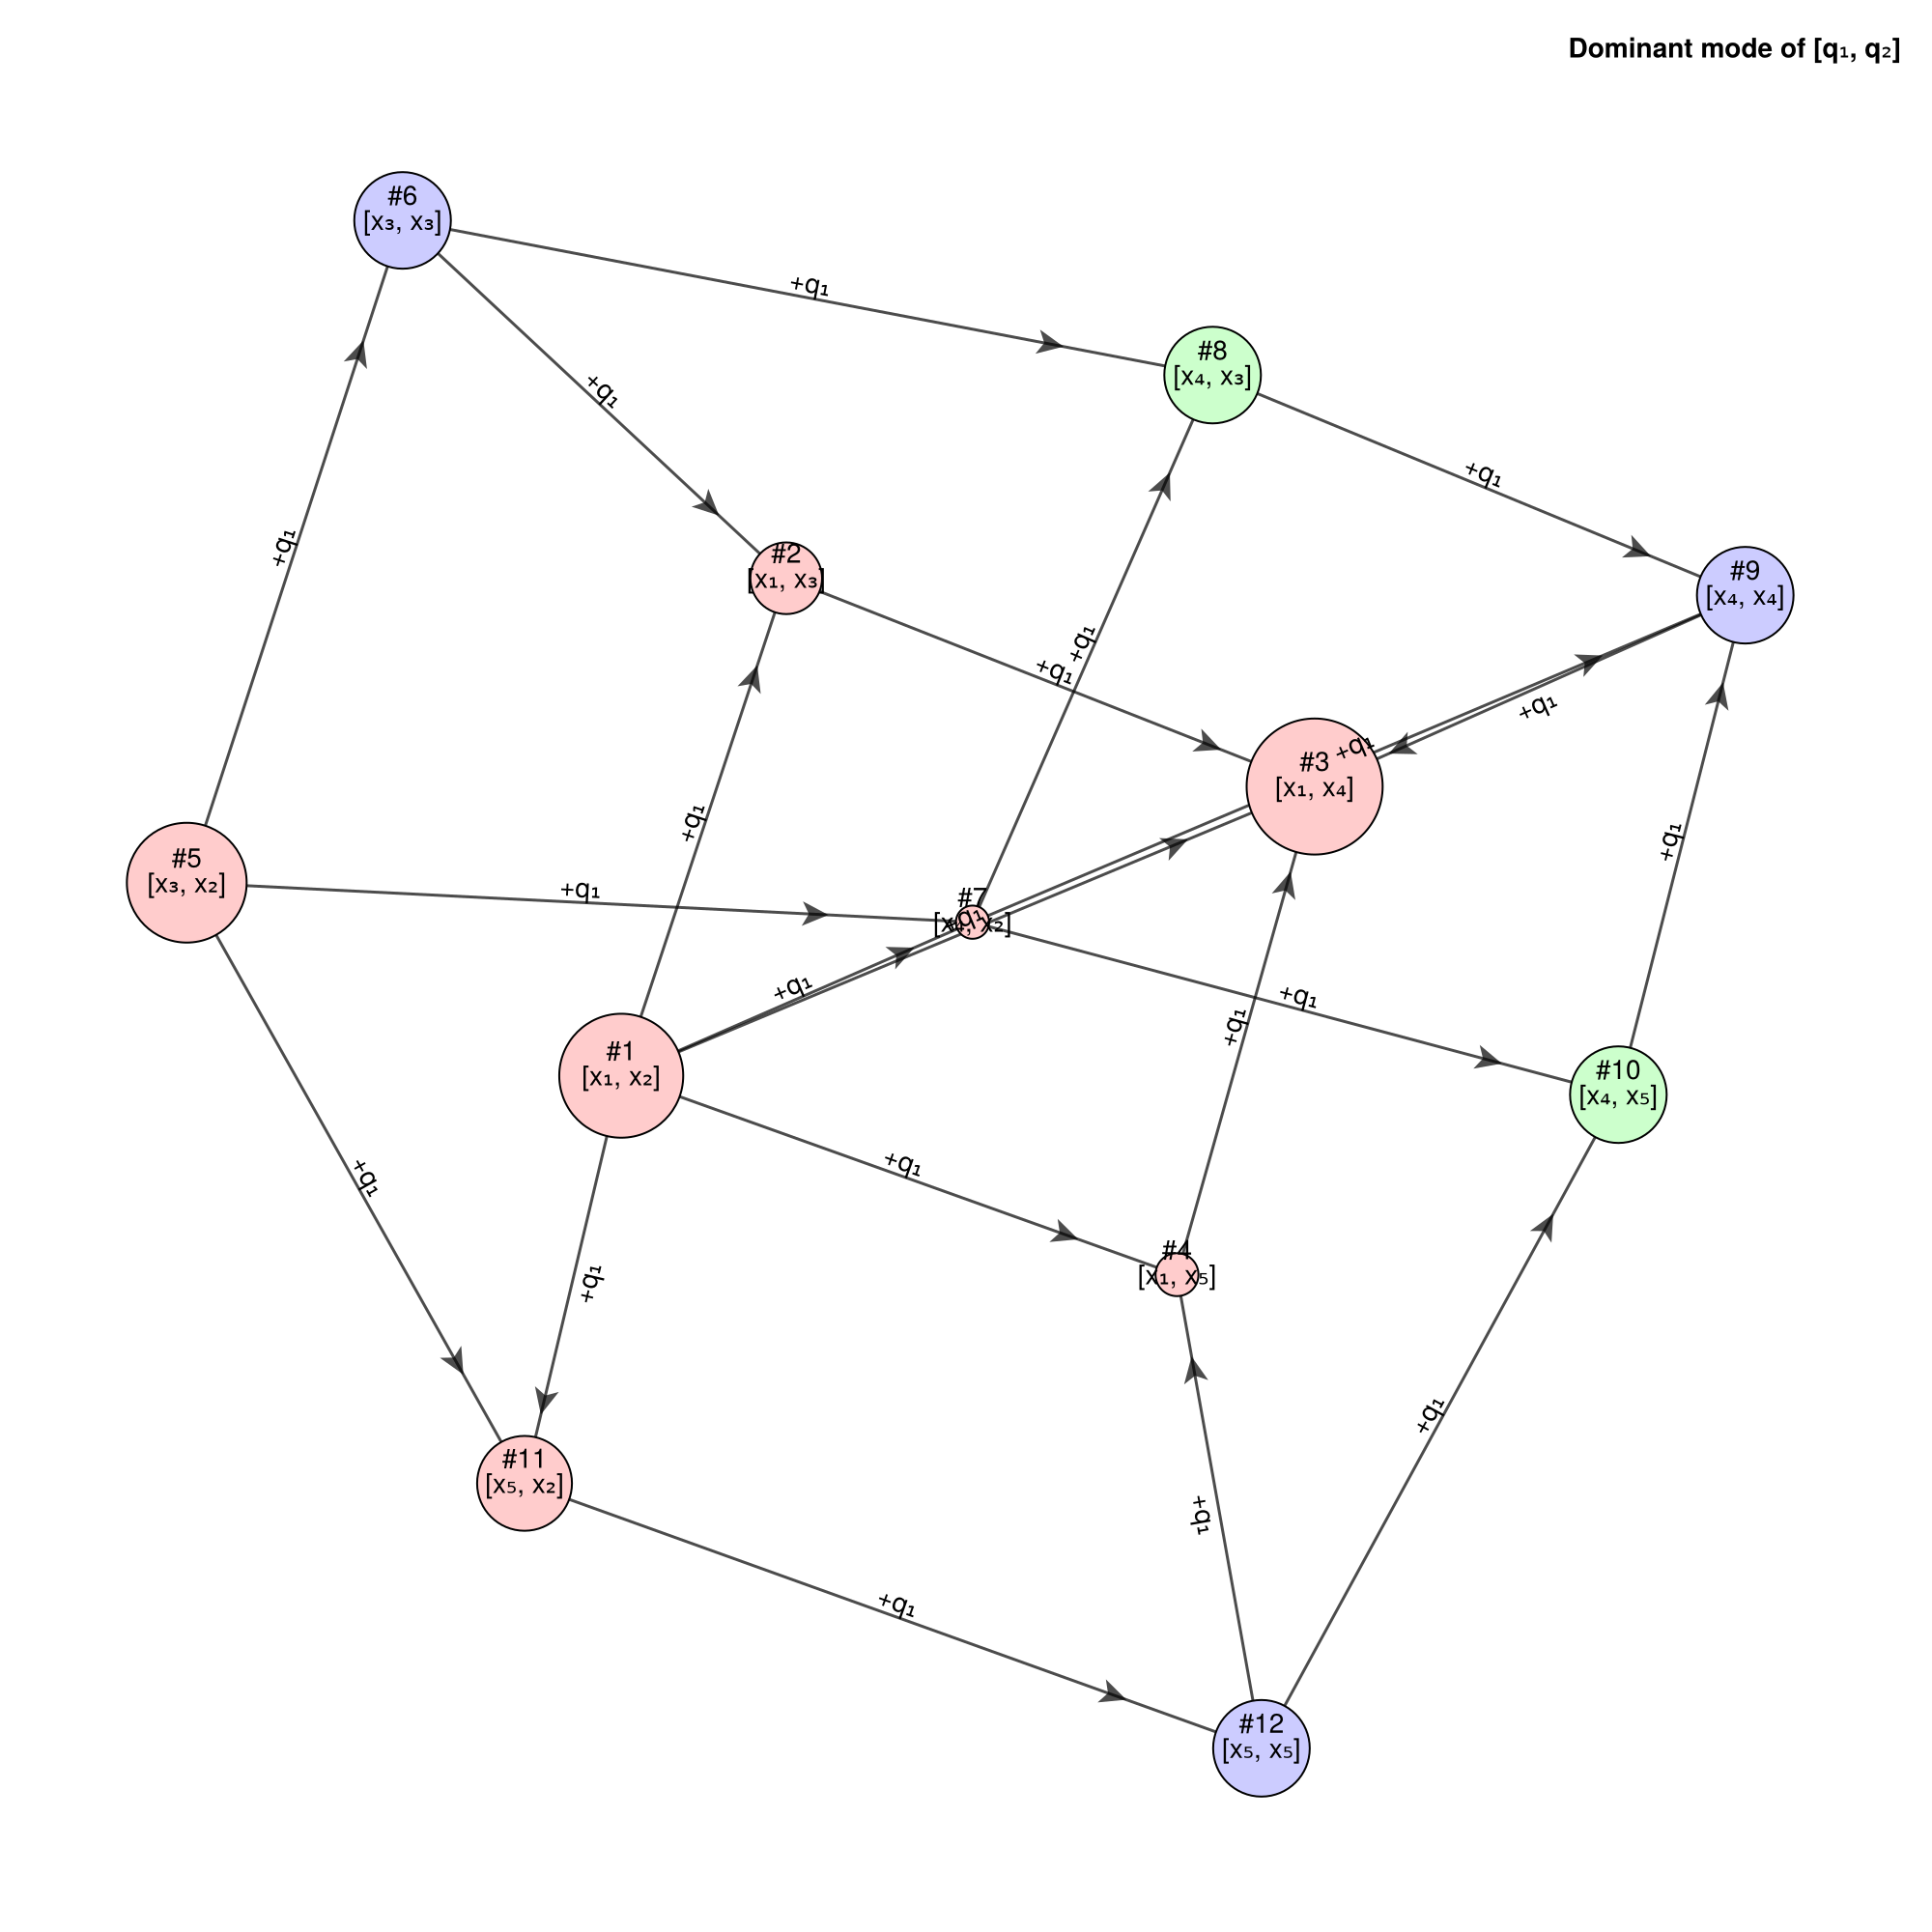

CairoMakie.Screen{IMAGE}


In [66]:
f,ax,p = draw_graph(pths)
display(f)

In [67]:
summary(pths)

[ Info: Start building polyhedra for edges (total: 21)
[ Info: Start building polyhedra for paths (total: 15)
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
[ Info: Number of polyhedra to calc volume: 11


Path 1         #1 → #2 → #3                    Volume: 0.1457 ± 0.0007
Path 2         #1 → #3                         Volume: 0.1738 ± 0.0008
Path 3         #1 → #4 → #3                    Volume: 0.0625 ± 0.0003
Path 4         #1 → #7 → #8 → #9 → #3          Volume: 0.0000 ± 0.0000
Path 5         #1 → #7 → #9 → #3               Volume: 0.0342 ± 0.0002
Path 6         #1 → #7 → #10 → #9 → #3         Volume: 0.0000 ± 0.0000
Path 7         #1 → #11 → #12 → #4 → #3        Volume: 0.0624 ± 0.0003
Path 8         #1 → #11 → #12 → #10 → #9 → #3  Volume: 0.0208 ± 0.0001
Path 9         #5 → #6 → #2 → #3               Volume: 0.1467 ± 0.0007
Path 10        #5 → #6 → #8 → #9 → #3          Volume: 0.0834 ± 0.0004
Path 11        #5 → #7 → #8 → #9 → #3          Volume: 0.0000 ± 0.0000
Path 12        #5 → #7 → #9 → #3               Volume: 0.0417 ± 0.0002
Path 13        #5 → #7 → #10 → #9 → #3         Volume: 0.0000 ± 0.0000
Path 14        #5 → #11 → #12 → #4 → #3        Volume: 0.0625 ± 0.0003
Path 1

[ Info: All regimes converged after 7300000 samples.


In [68]:
get_RO_paths(pths; observe_x=1)

15-element Vector{Vector{<:Real}}:
 [1.0, 1.0, 1.0]
 [1.0, 1.0]
 [1.0, 1.0, 1.0]
 [1.0, 0.5, 1.0, Inf, 1.0]
 [1.0, 0.5, Inf, 1.0]
 [1.0, 0.5, 1.0, Inf, 1.0]
 [1.0, 0.5, Inf, 1.0, 1.0]
 [1.0, 0.5, Inf, 1.0, Inf, 1.0]
 [1.0, Inf, 1.0, 1.0]
 [1.0, Inf, 1.0, Inf, 1.0]
 [1.0, 0.5, 1.0, Inf, 1.0]
 [1.0, 0.5, Inf, 1.0]
 [1.0, 0.5, 1.0, Inf, 1.0]
 [1.0, 0.5, Inf, 1.0, 1.0]
 [1.0, 0.5, Inf, 1.0, Inf, 1.0]

In [69]:
get_RO_paths(pths; observe_x=2, deduplicate=true)

15-element Vector{Vector{<:Real}}:
 [0.0, -1.0, -2.0]
 [0.0, -2.0]
 [0.0, -1.0, -2.0]
 [0.0, -1.0, -Inf, -2.0]
 [0.0, -Inf, -2.0]
 [0.0, -1.0, -Inf, -2.0]
 [0.0, -Inf, -1.0, -2.0]
 [0.0, -Inf, -1.0, -Inf, -2.0]
 [0.0, -Inf, -1.0, -2.0]
 [0.0, -Inf, -1.0, -Inf, -2.0]
 [0.0, -1.0, -Inf, -2.0]
 [0.0, -Inf, -2.0]
 [0.0, -1.0, -Inf, -2.0]
 [0.0, -Inf, -1.0, -2.0]
 [0.0, -Inf, -1.0, -Inf, -2.0]

In [70]:
get_RO_paths(pths; observe_x=2, deduplicate=true, keep_nonasymptotic=false,keep_singular=false)

15-element Vector{Vector{<:Real}}:
 [0.0, -1.0, -2.0]
 [0.0, -2.0]
 [0.0, -1.0, -2.0]
 [0.0, -2.0]
 [0.0, -2.0]
 [0.0, -2.0]
 [0.0, -1.0, -2.0]
 [0.0, -2.0]
 [0.0, -1.0, -2.0]
 [0.0, -2.0]
 [0.0, -2.0]
 [0.0, -2.0]
 [0.0, -2.0]
 [0.0, -1.0, -2.0]
 [0.0, -2.0]

In [71]:
summary_RO_path(pths;observe_x=5, deduplicate=true, keep_nonasymptotic=false,keep_singular=false)

Path [1, 3, 9]                     2 → 0 → -2      Volume: 0.3549 ± 0.0011
Path [4, 5, 6, 8, 11, 12, 13, 15]  2 → 1 → -2      Volume: 0.2631 ± 0.0009
Path [2, 10]                       2 → -2          Volume: 0.2572 ± 0.0009
Path [7, 14]                       2 → 1 → 0 → -2  Volume: 0.1249 ± 0.0004


parameters = [4.461420286601642, 7.289847411347832, 0.738589194628696, 0.0]


[ Info: Change in logq₁
[ Info: parameters: Pair{Symbolics.Num, Float64}[q₂ => 4.461420286601642, K₁ => 7.289847411347832, K₂ => 0.738589194628696, K₃ => 0.0]
[ Info: Target syms contains: logx₁ 
[ Info: Target syms contains: logx₂ 
[ Info: Target syms contains: logx₃ 
[ Info: Target syms contains: logx₄ 
[ Info: Target syms contains: logx₅ 


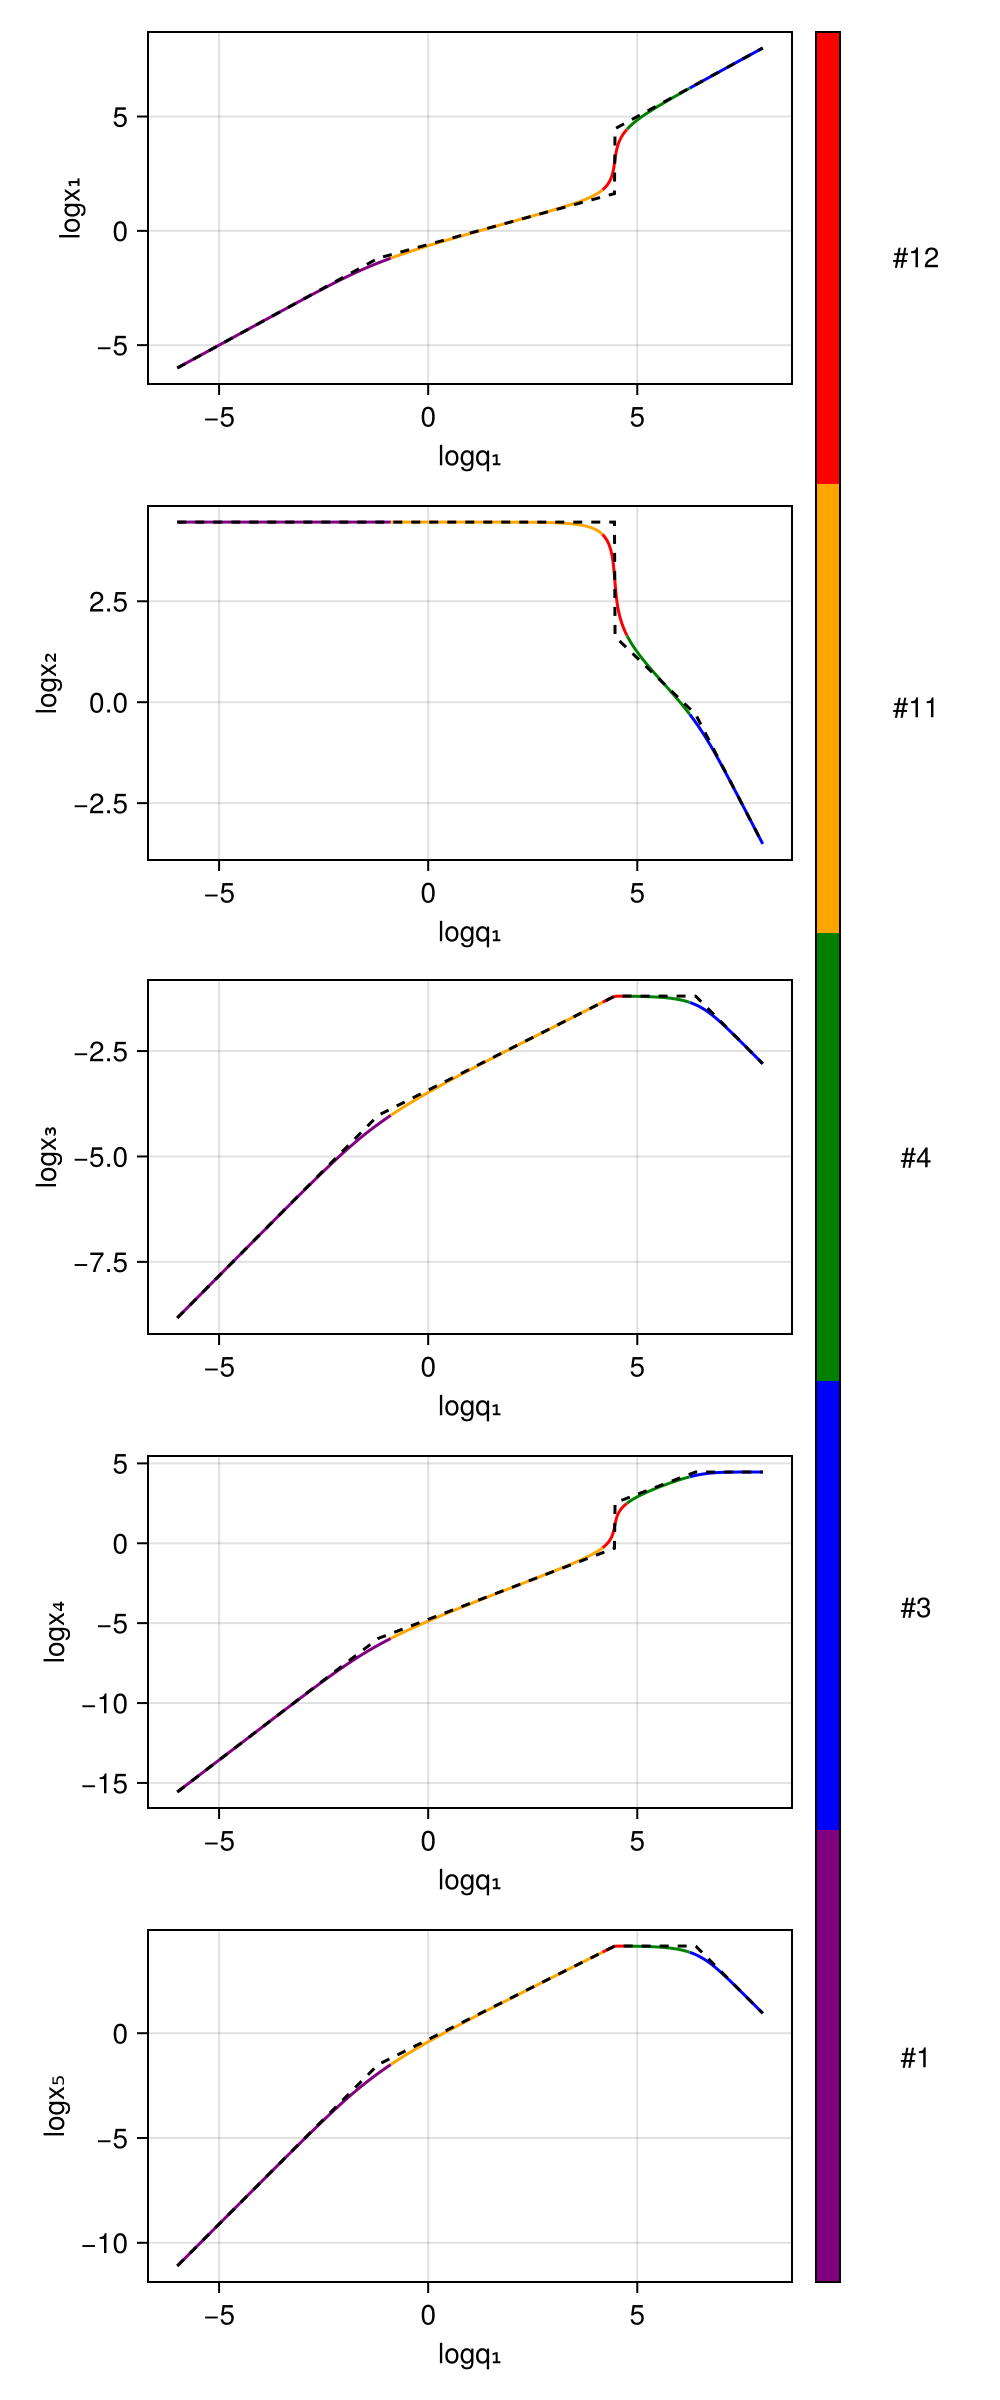

In [72]:
SISO_plot(pths,7; 
    add_archeatype_lines=true, 
    size = (500,1200),
    start=-6, 
    stop = 8)

## Numerical mapping


Mapping directly between x space and qK space:


In [73]:
logqK_vec = randomize(model,4;log_lower=-6, log_upper=6) # generate a vector of qK

4-element Vector{Vector{Float64}}:
 [-3.733041497924596, -0.5441662969073437, -3.6562812457560505]
 [-5.112585842171045, -5.862621354553017, 4.627901539177659]
 [2.650315051693184, 2.8495799851841337, -5.996319580993376]
 [5.339788263632251, -3.8756930641448126, -4.45532810083456]

In [74]:
logx_vec = logqK_vec .|> qK-> qK2x(model,qK; input_logspace=true, output_logspace=true)# map qK vector to x space

4-element Vector{Vector{Float64}}:
 [-6.845211011351326, -0.5444473018996681, -3.733377067494944]
 [-5.112585842185082, -5.8626213546319565, -15.603108735994697]
 [-5.761401443168188, 2.4153969121850594, 2.6503150500102475]
 [5.339788263367826, -13.670809428416808, -3.8756930642144214]

In [75]:
logqK_vec2 = logx_vec .|> x-> x2qK(model,x; input_logspace=true, output_logspace=true) # map x vector back to qK space

4-element Vector{Vector{Float64}}:
 [-3.733041497924596, -0.5441662969073439, -3.65628124575605]
 [-5.112585842171045, -5.862621354553016, 4.627901539177659]
 [2.6503150516931844, 2.8495799851839574, -5.996319580993376]
 [5.339788263632251, -3.875693064144812, -4.455328100834561]

In [76]:
logqK_vec2.-logqK_vec # check the difference, should be close to zero vector

4-element Vector{Vector{Float64}}:
 [0.0, -1.1102230246251565e-16, 4.440892098500626e-16]
 [0.0, 8.881784197001252e-16, 0.0]
 [4.440892098500626e-16, -1.7630341631047486e-13, 0.0]
 [0.0, 4.440892098500626e-16, -8.881784197001252e-16]

Assign regimes based on sampled points:


In [77]:
logqK_vec .|> qK -> assign_vertex(model,qK; input_logspace=true, asymptotic_only=false, return_idx=true)

4-element Vector{Int64}:
 3
 1
 3
 2

In [78]:
logx_rgm = logqK_vec .|> qK -> qK2x(model,qK; input_logspace=true, output_logspace=true, use_vtx=true)

4-element Vector{Vector{Float64}}:
 [-6.845156446773302, -0.5441662969073437, -3.733041497924596]
 [-5.112585842171045, -5.862621354553017, -15.60310873590172]
 [-6.195584514484326, 2.8495799851841337, 2.650315051693184]
 [5.339788263632251, -13.670809428611623, -3.8756930641448126]

In [79]:
logx_rgm .- logx_vec # check the difference, should likely be close

4-element Vector{Vector{Float64}}:
 [5.45645780238857e-5, 0.0002810049923243074, 0.0003355695703479711]
 [1.4036771744940779e-11, 7.893952158610773e-11, 9.297629333104851e-11]
 [-0.43418307131613787, 0.4341830729990743, 1.6829364568593519e-9]
 [2.644249263994425e-10, -1.9481483093386487e-10, 6.960876319794806e-11]

Plot to compare the direct solver and regime-based approximation:


In [80]:
logK=0
logE_rg = (-6,6)
logS_rg = (-6,6)
# total_points = 1e6 # points each dimension
pts_each_dim =1000



logx = begin 
    data = Matrix{Vector{Float64}}(undef, pts_each_dim, pts_each_dim)
    
    # fill the first axis with chaning tS
    startqK = [logE_rg[1], logS_rg[1],  logK] # pass parameter in tE,tS, K order
    endqK = [logE_rg[1], logS_rg[2],logK]
    data[:,1] .= x_traj_with_qK_change(model,startqK,endqK; 
        input_logspace=true, output_logspace=true,npoints=pts_each_dim)[2]

    # fill the second axis with changing tE
    start_logS = range(logS_rg..., length=pts_each_dim)
    Threads.@threads for i in 1:pts_each_dim
        startqK = [logE_rg[1], start_logS[i],  logK] 
        endqK = [logE_rg[2], start_logS[i], logK]
        # start_logx = data[i,1]
        data[i,1:end] .= x_traj_with_qK_change(model, startqK, endqK; 
            # startlogx = start_logx, 
            input_logspace=true, output_logspace=true,npoints=pts_each_dim)[2]
    end
    data
end

# MM_C(Et,St,K) = Et*St/(St+K)
# logC_MM = log10.(
#     MM_C.(
#         exp10.(range(logS_rg...,pts_each_dim)),
#         exp10.(range(logE_rg...,pts_each_dim)')
#         ,1)
#     )

logx_rgm = let
    data = Matrix{Vector{Float64}}(undef, pts_each_dim,pts_each_dim)
    lgS = range(logS_rg..., length=pts_each_dim)
    lgE = range(logE_rg..., length=pts_each_dim)
    Threads.@threads for i in 1:pts_each_dim
        for j in 1:pts_each_dim
            logqK = [lgE[j], lgS[i], logK]
            data[i,j] = qK2x(model, logqK;input_logspace=true,output_logspace=true, use_vtx=true)
        end
    end
    data
end

1000×1000 Matrix{Vector{Float64}}:
 [-6.0, -6.0, -12.0]         …  [6.0, -12.0, -6.0]
 [-6.0, -5.98799, -11.988]      [6.0, -11.988, -5.98799]
 [-6.0, -5.97598, -11.976]      [6.0, -11.976, -5.97598]
 [-6.0, -5.96396, -11.964]      [6.0, -11.964, -5.96396]
 [-6.0, -5.95195, -11.952]      [6.0, -11.952, -5.95195]
 [-6.0, -5.93994, -11.9399]  …  [6.0, -11.9399, -5.93994]
 [-6.0, -5.92793, -11.9279]     [6.0, -11.9279, -5.92793]
 [-6.0, -5.91592, -11.9159]     [6.0, -11.9159, -5.91592]
 [-6.0, -5.9039, -11.9039]      [6.0, -11.9039, -5.9039]
 [-6.0, -5.89189, -11.8919]     [6.0, -11.8919, -5.89189]
 [-6.0, -5.87988, -11.8799]  …  [6.0, -11.8799, -5.87988]
 [-6.0, -5.86787, -11.8679]     [6.0, -11.8679, -5.86787]
 [-6.0, -5.85586, -11.8559]     [6.0, -11.8559, -5.85586]
 ⋮                           ⋱  
 [-11.8679, 5.86787, -6.0]      [6.0, -0.132132, 5.86787]
 [-11.8799, 5.87988, -6.0]      [6.0, -0.12012, 5.87988]
 [-11.8919, 5.89189, -6.0]   …  [6.0, -0.108108, 5.89189]
 [-11.9039, 5.903

In [82]:
# assign regimes according to different criteria.
col_asym_x = logx .|> x->assign_vertex_x(model, x,input_logspace=true; asymptotic_only=true,return_idx=true)
col_nonasym_x = logx .|> x->assign_vertex_x(model, x,input_logspace=true; asymptotic_only=false,return_idx=true)
col_asym_qK = logx .|> x->assign_vertex_qK(model; x=x,input_logspace=true , asymptotic_only=true,return_idx=true) 
col_nonasym_qK = logx .|> x->assign_vertex_qK(model; x=x,input_logspace=true , asymptotic_only=false,return_idx=true)


# find the boundary between different regimes.
bnds_asym_x = find_bounds(col_asym_x)
bnds_nonasym_x = find_bounds(col_nonasym_x)
bnds_asym_qK = find_bounds(col_asym_qK)
bnds_nonasym_qK = find_bounds(col_nonasym_qK)

cmap = get_color_map(col_nonasym_x)
print("Done")

Done

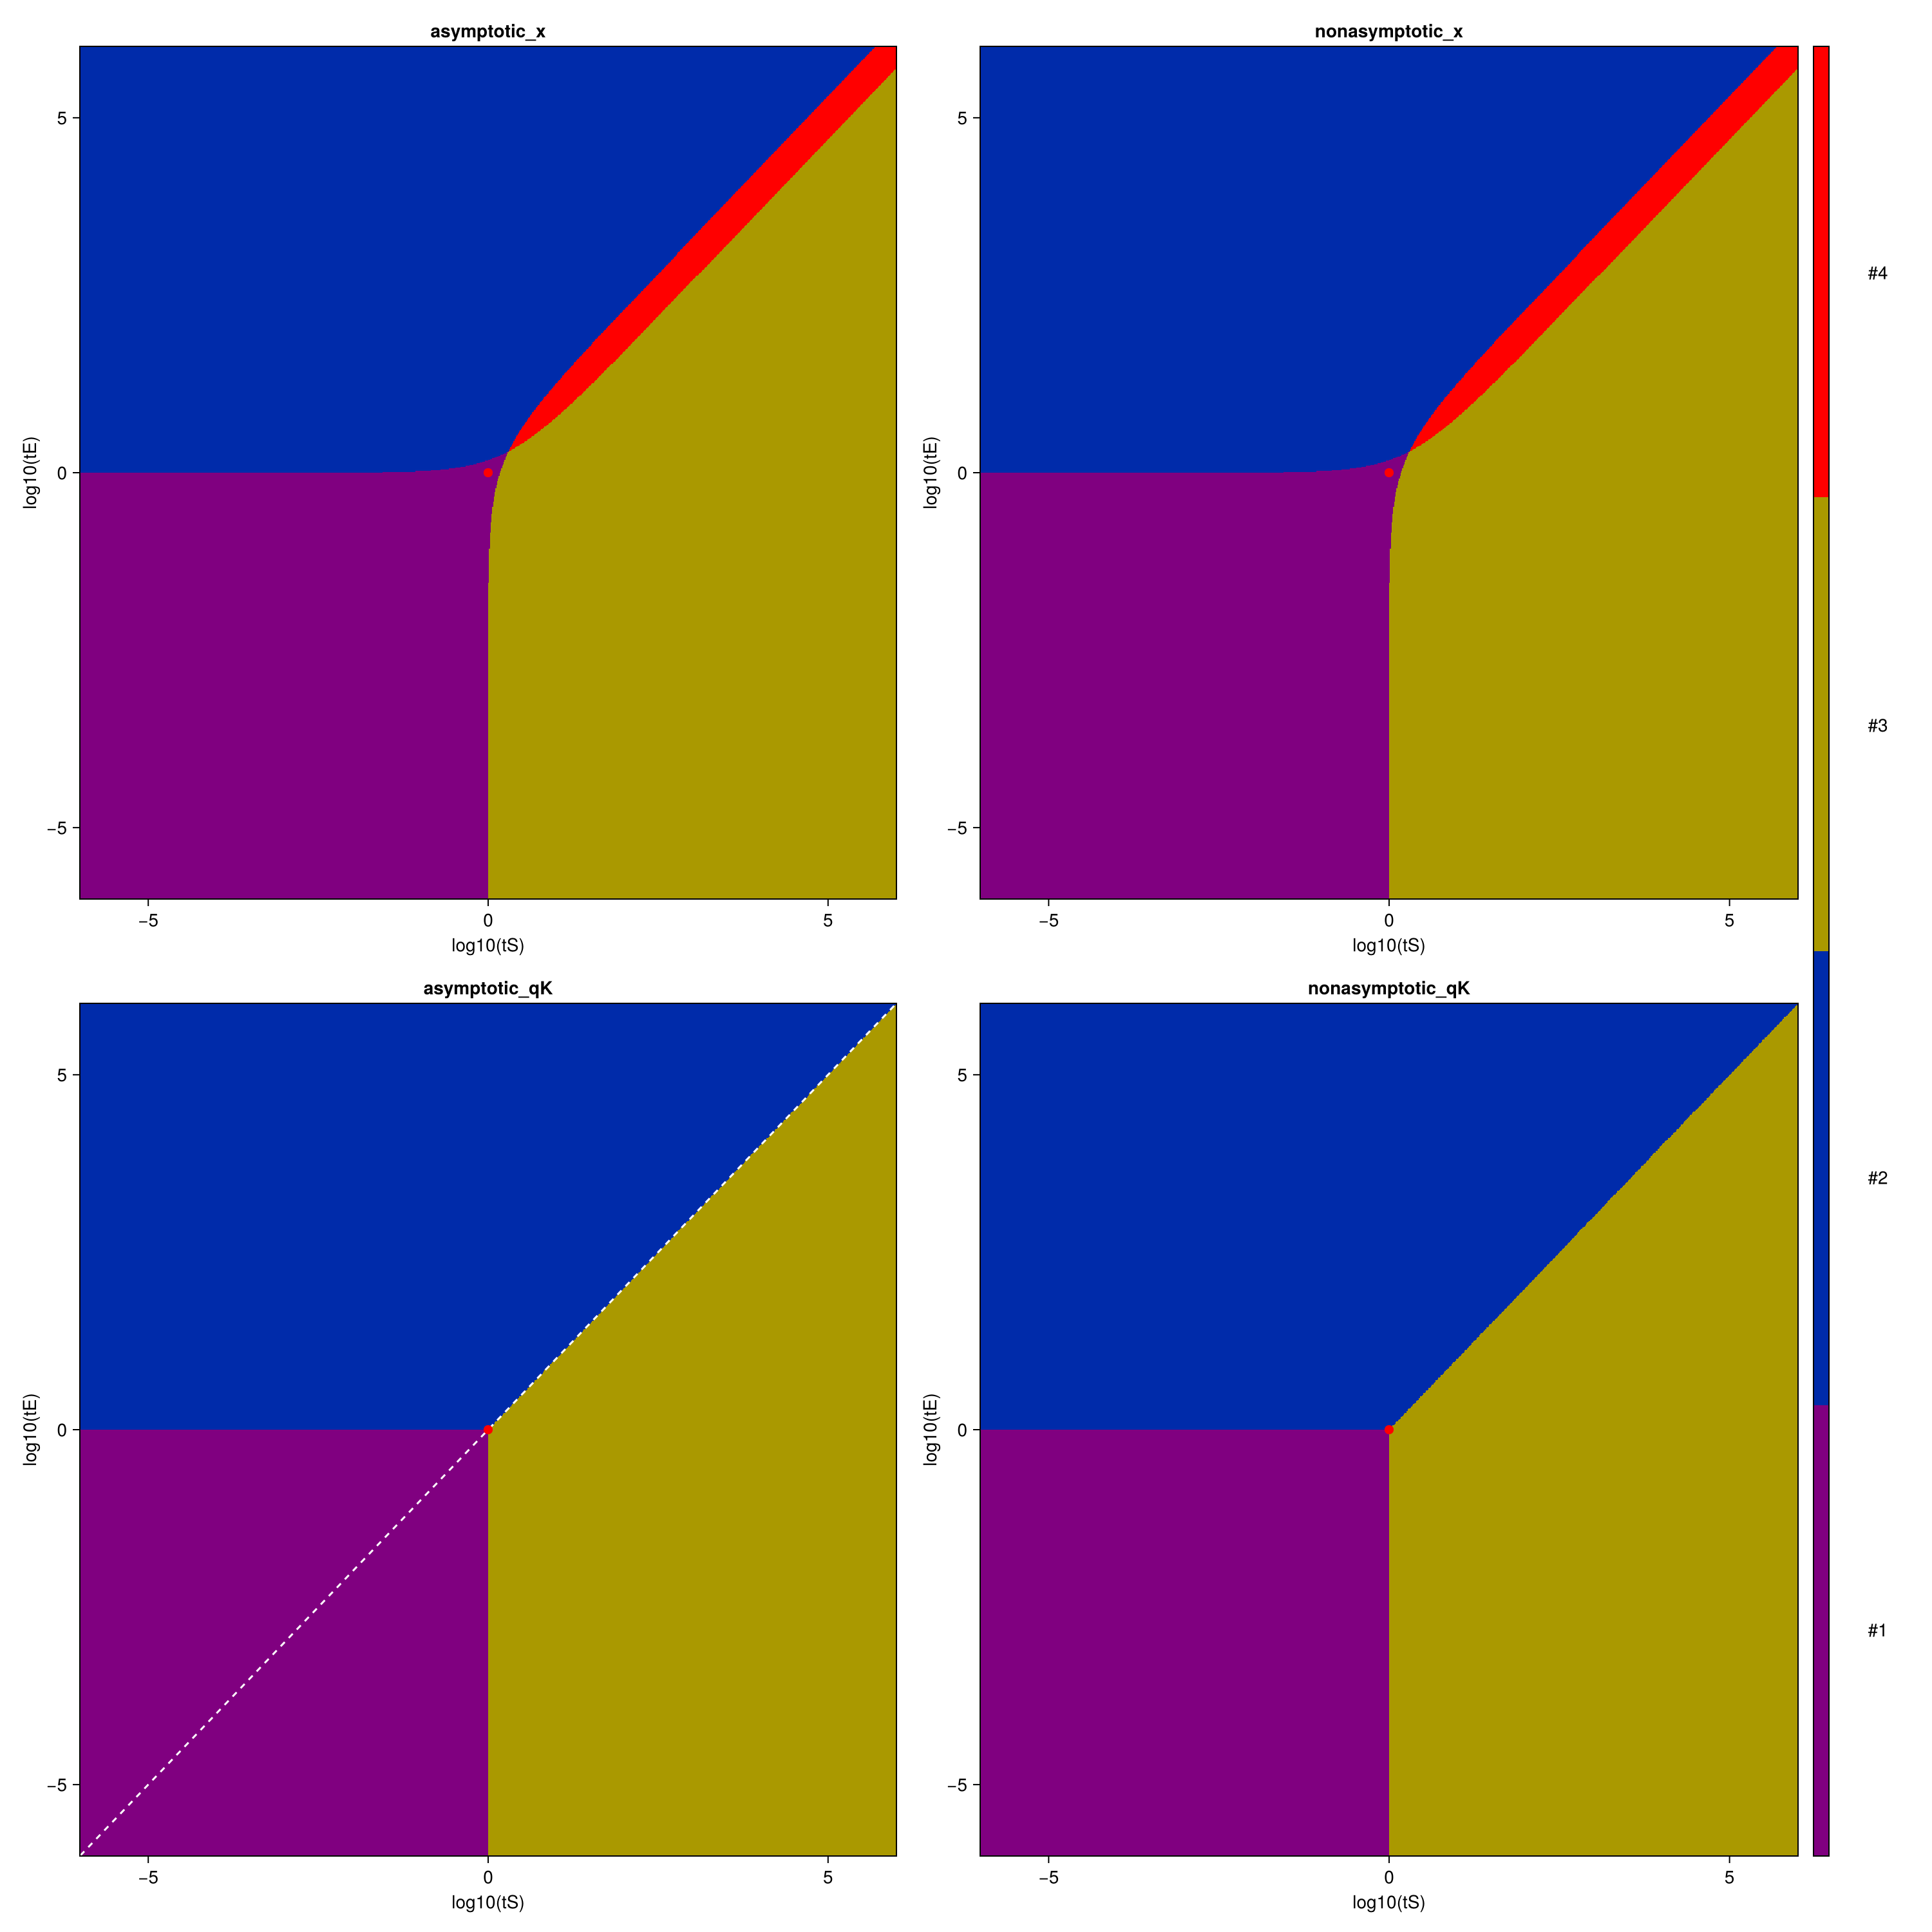

CairoMakie.Screen{IMAGE}


In [83]:
f = Figure(size=(1500,1500))
p1 = Axis(f[1, 1])
p2 = Axis(f[1, 2])
p3 = Axis(f[2, 1])
p4 = Axis(f[2, 2])

# --- Plot 1: asymptotic_x ---
p1.title = "asymptotic_x"
heatmap!(p1, logS_rg, logE_rg, getindex.(Ref(cmap), col_asym_x))
# contour!(p1, logE_rg, logS_rg, bnds_nonasym_x,color = :black)
# --- Plot 2: nonasymptotic_x ---
p2.title = "nonasymptotic_x"
heatmap!(p2, logS_rg, logE_rg, getindex.(Ref(cmap), col_nonasym_x))
# --- Plot 3: asymptotic_qK ---
p3.title = "asymptotic_qK"
heatmap!(p3,  logS_rg, logE_rg, getindex.(Ref(cmap), col_asym_qK))
# contour!(p3, logE_rg, logS_rg, bnds_nonasym_x, color = :black)
lines!(p3, [-6,6], [-6,6], color=:white, linestyle=:dash)

# --- Plot 4: nonasymptotic_qK ---
p4.title = "nonasymptotic_qK"
heatmap!(p4, logS_rg, logE_rg, getindex.(Ref(cmap), col_nonasym_qK))
# contour!(p4, logE_rg, logS_rg, bnds_nonasym_x,color = :black)

for p in [p1, p2, p3, p4]
    # Add the red dot
    scatter!(p, [logK], [logK], marker=:circle, markersize=10, color=:red)
    # Set the axis labels (modern syntax)
    p.xlabel = "log10(tS)"
    p.ylabel = "log10(tE)"
end

add_rgm_colorbar!(f,cmap)

display(f)

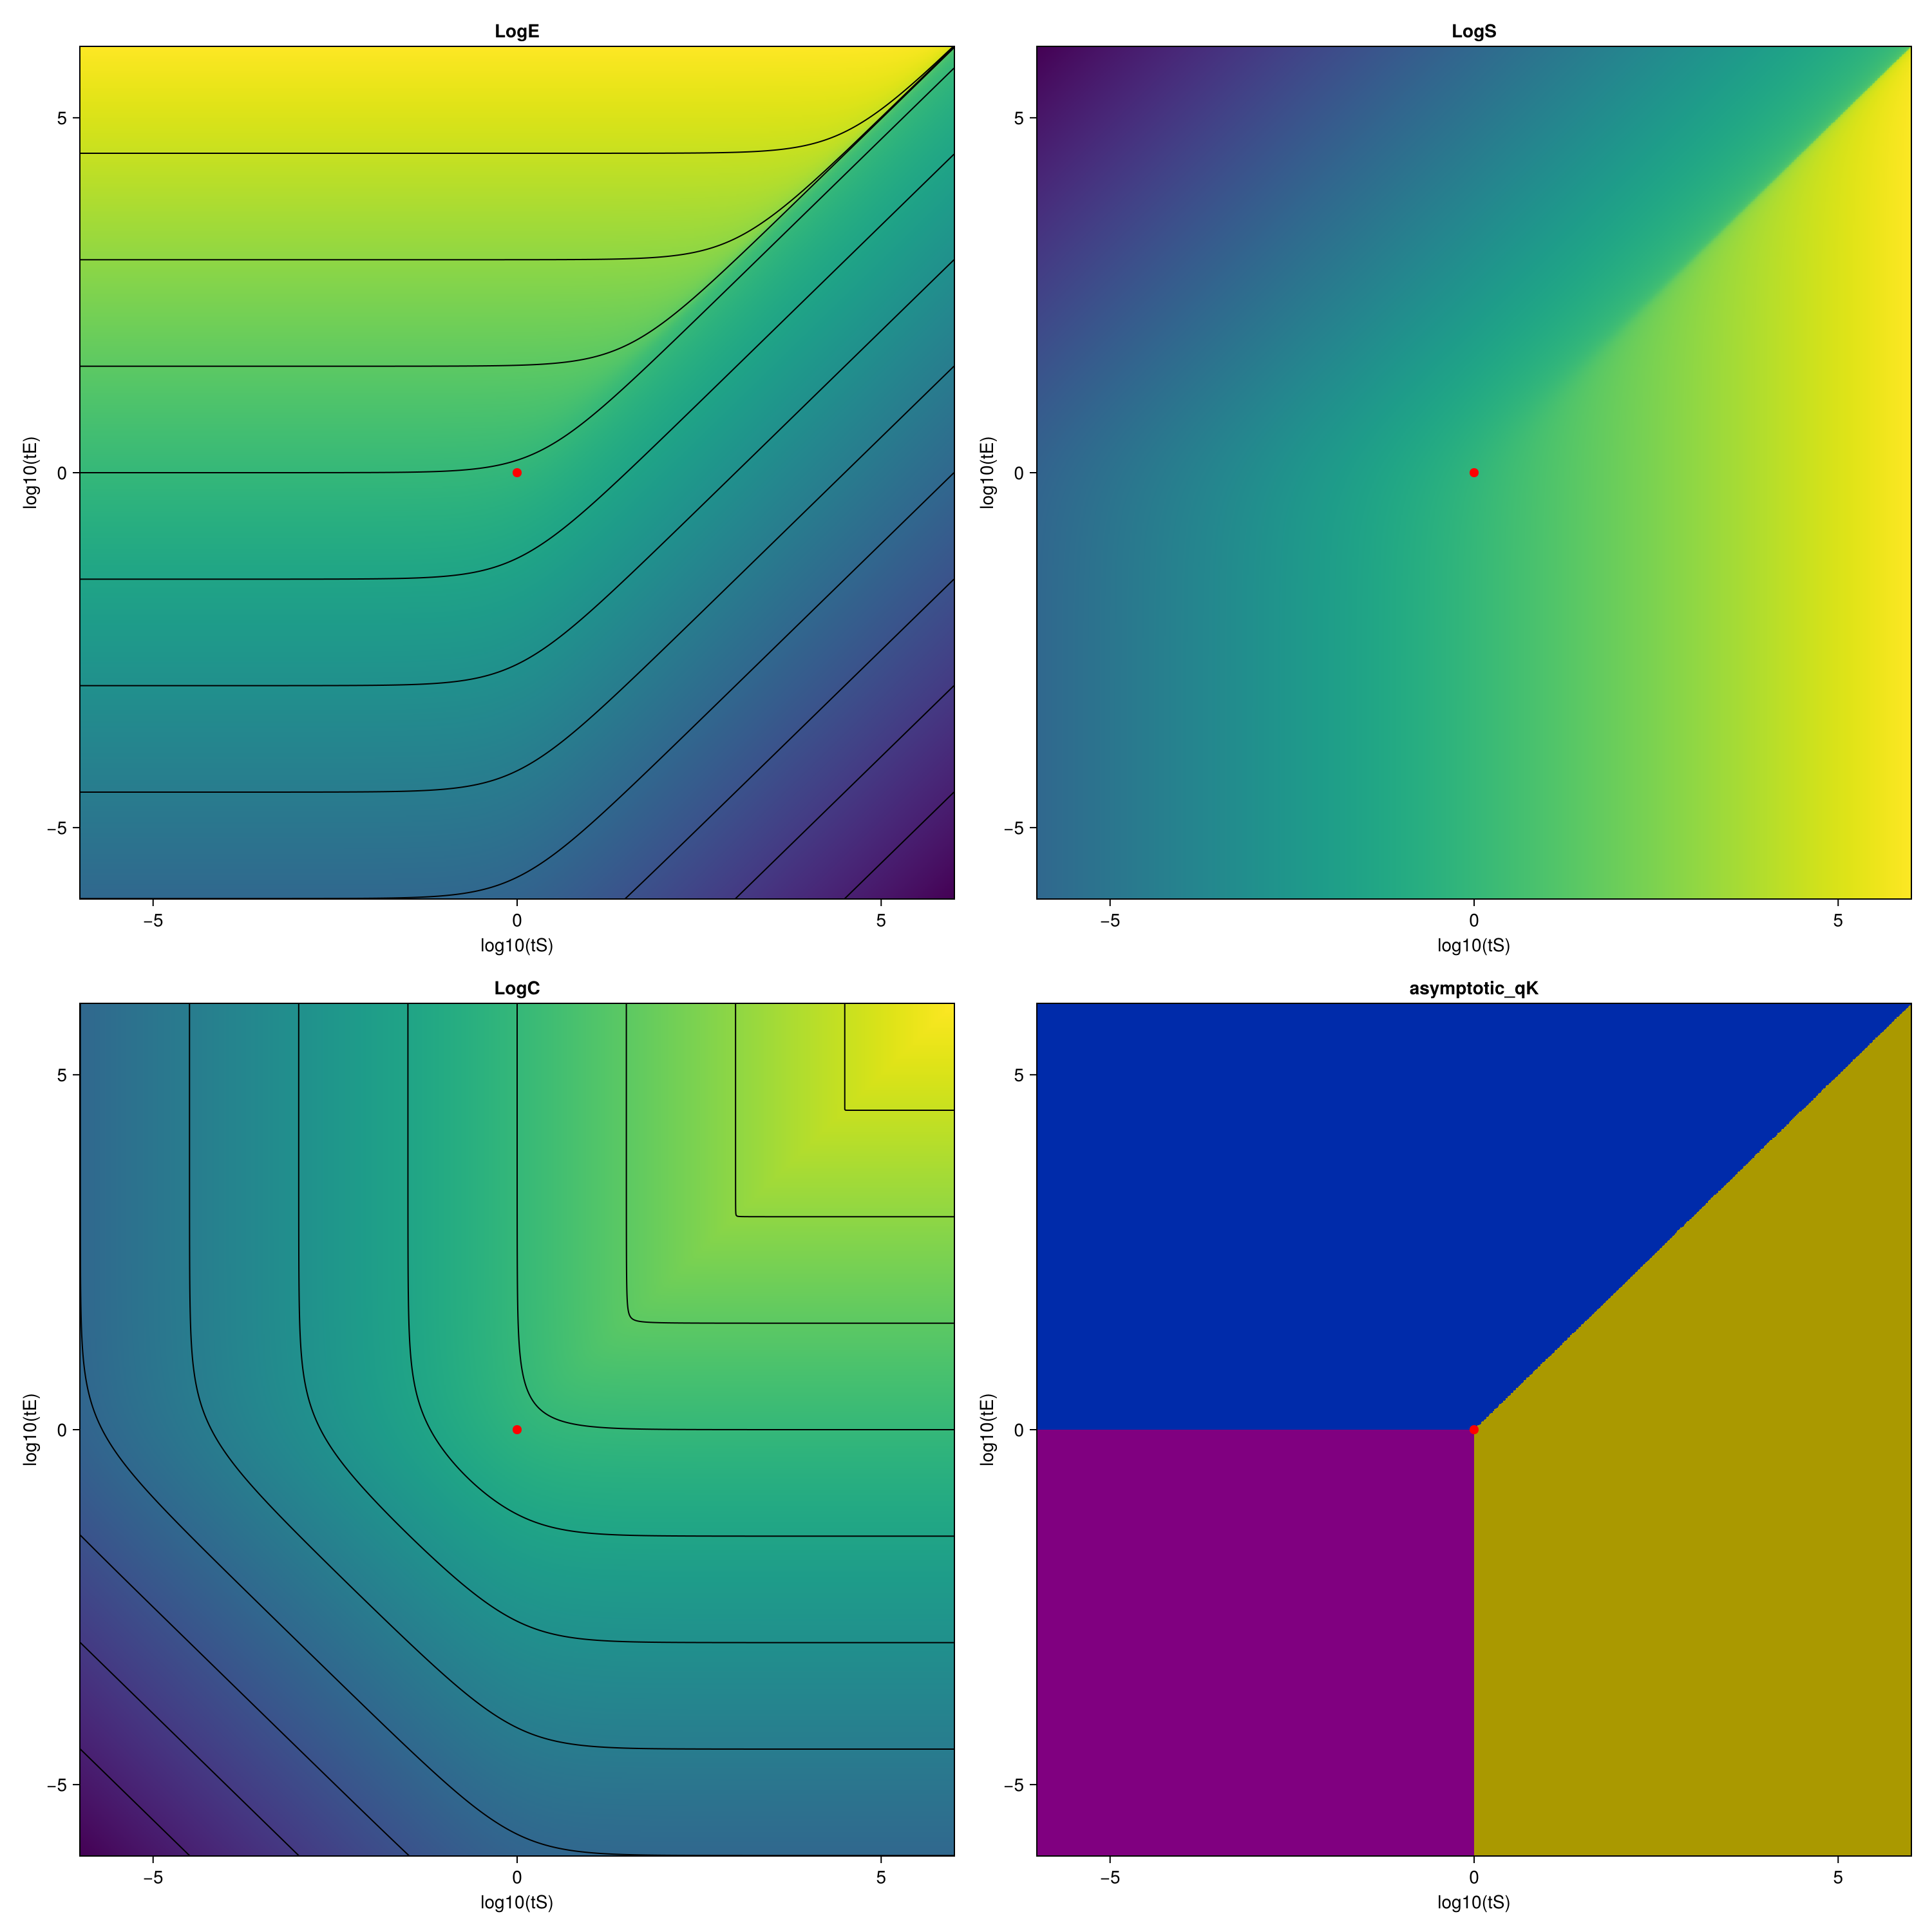

CairoMakie.Screen{IMAGE}


In [84]:
# using GLMakie
f = Figure(size=(1500,1500))
p1 = Axis(f[1, 1])
p2 = Axis(f[1, 2])
p3 = Axis(f[2, 1])
p4 = Axis(f[2, 2])


p1.title = "LogE"
heatmap!(p1, logS_rg, logE_rg, logx .|> x->x[1], colormap=:viridis)
contour!(p1, logS_rg, logE_rg, logx .|> x->x[1], color=:black, levels=-30:1.5:30)
# contour!(p1, logE_rg, logS_rg, bnds_nonasym_x,color = :black)

p2.title = "LogS"
heatmap!(p2, logS_rg, logE_rg, logx .|> x->x[2], colormap=:viridis)


p3.title = "LogC"
heatmap!(p3, logS_rg, logE_rg, logx .|> x->x[3], colormap=:viridis)
contour!(p3, logS_rg, logE_rg, logx .|> x->x[3], color=:black, levels=-30:1.5:30)
# lines!(p3, [-6,6], [-6,6], color=:white, linestyle=:dash)


p4.title = "asymptotic_qK"
heatmap!(p4, logS_rg, logE_rg, getindex.(Ref(cmap), col_asym_qK))
# contour!(p4, logE_rg, logS_rg, bnds_asym_qK, color = :black)

for p in [p1, p2, p3, p4]
    # Add the red dot
    scatter!(p, [logK], [logK], marker=:circle, markersize=10, color=:red)
    # Set the axis labels (modern syntax)
    p.xlabel = "log10(tS)"
    p.ylabel = "log10(tE)"
end
# Colorbar(f[:,end+1], colorrange = crange)

display(f)

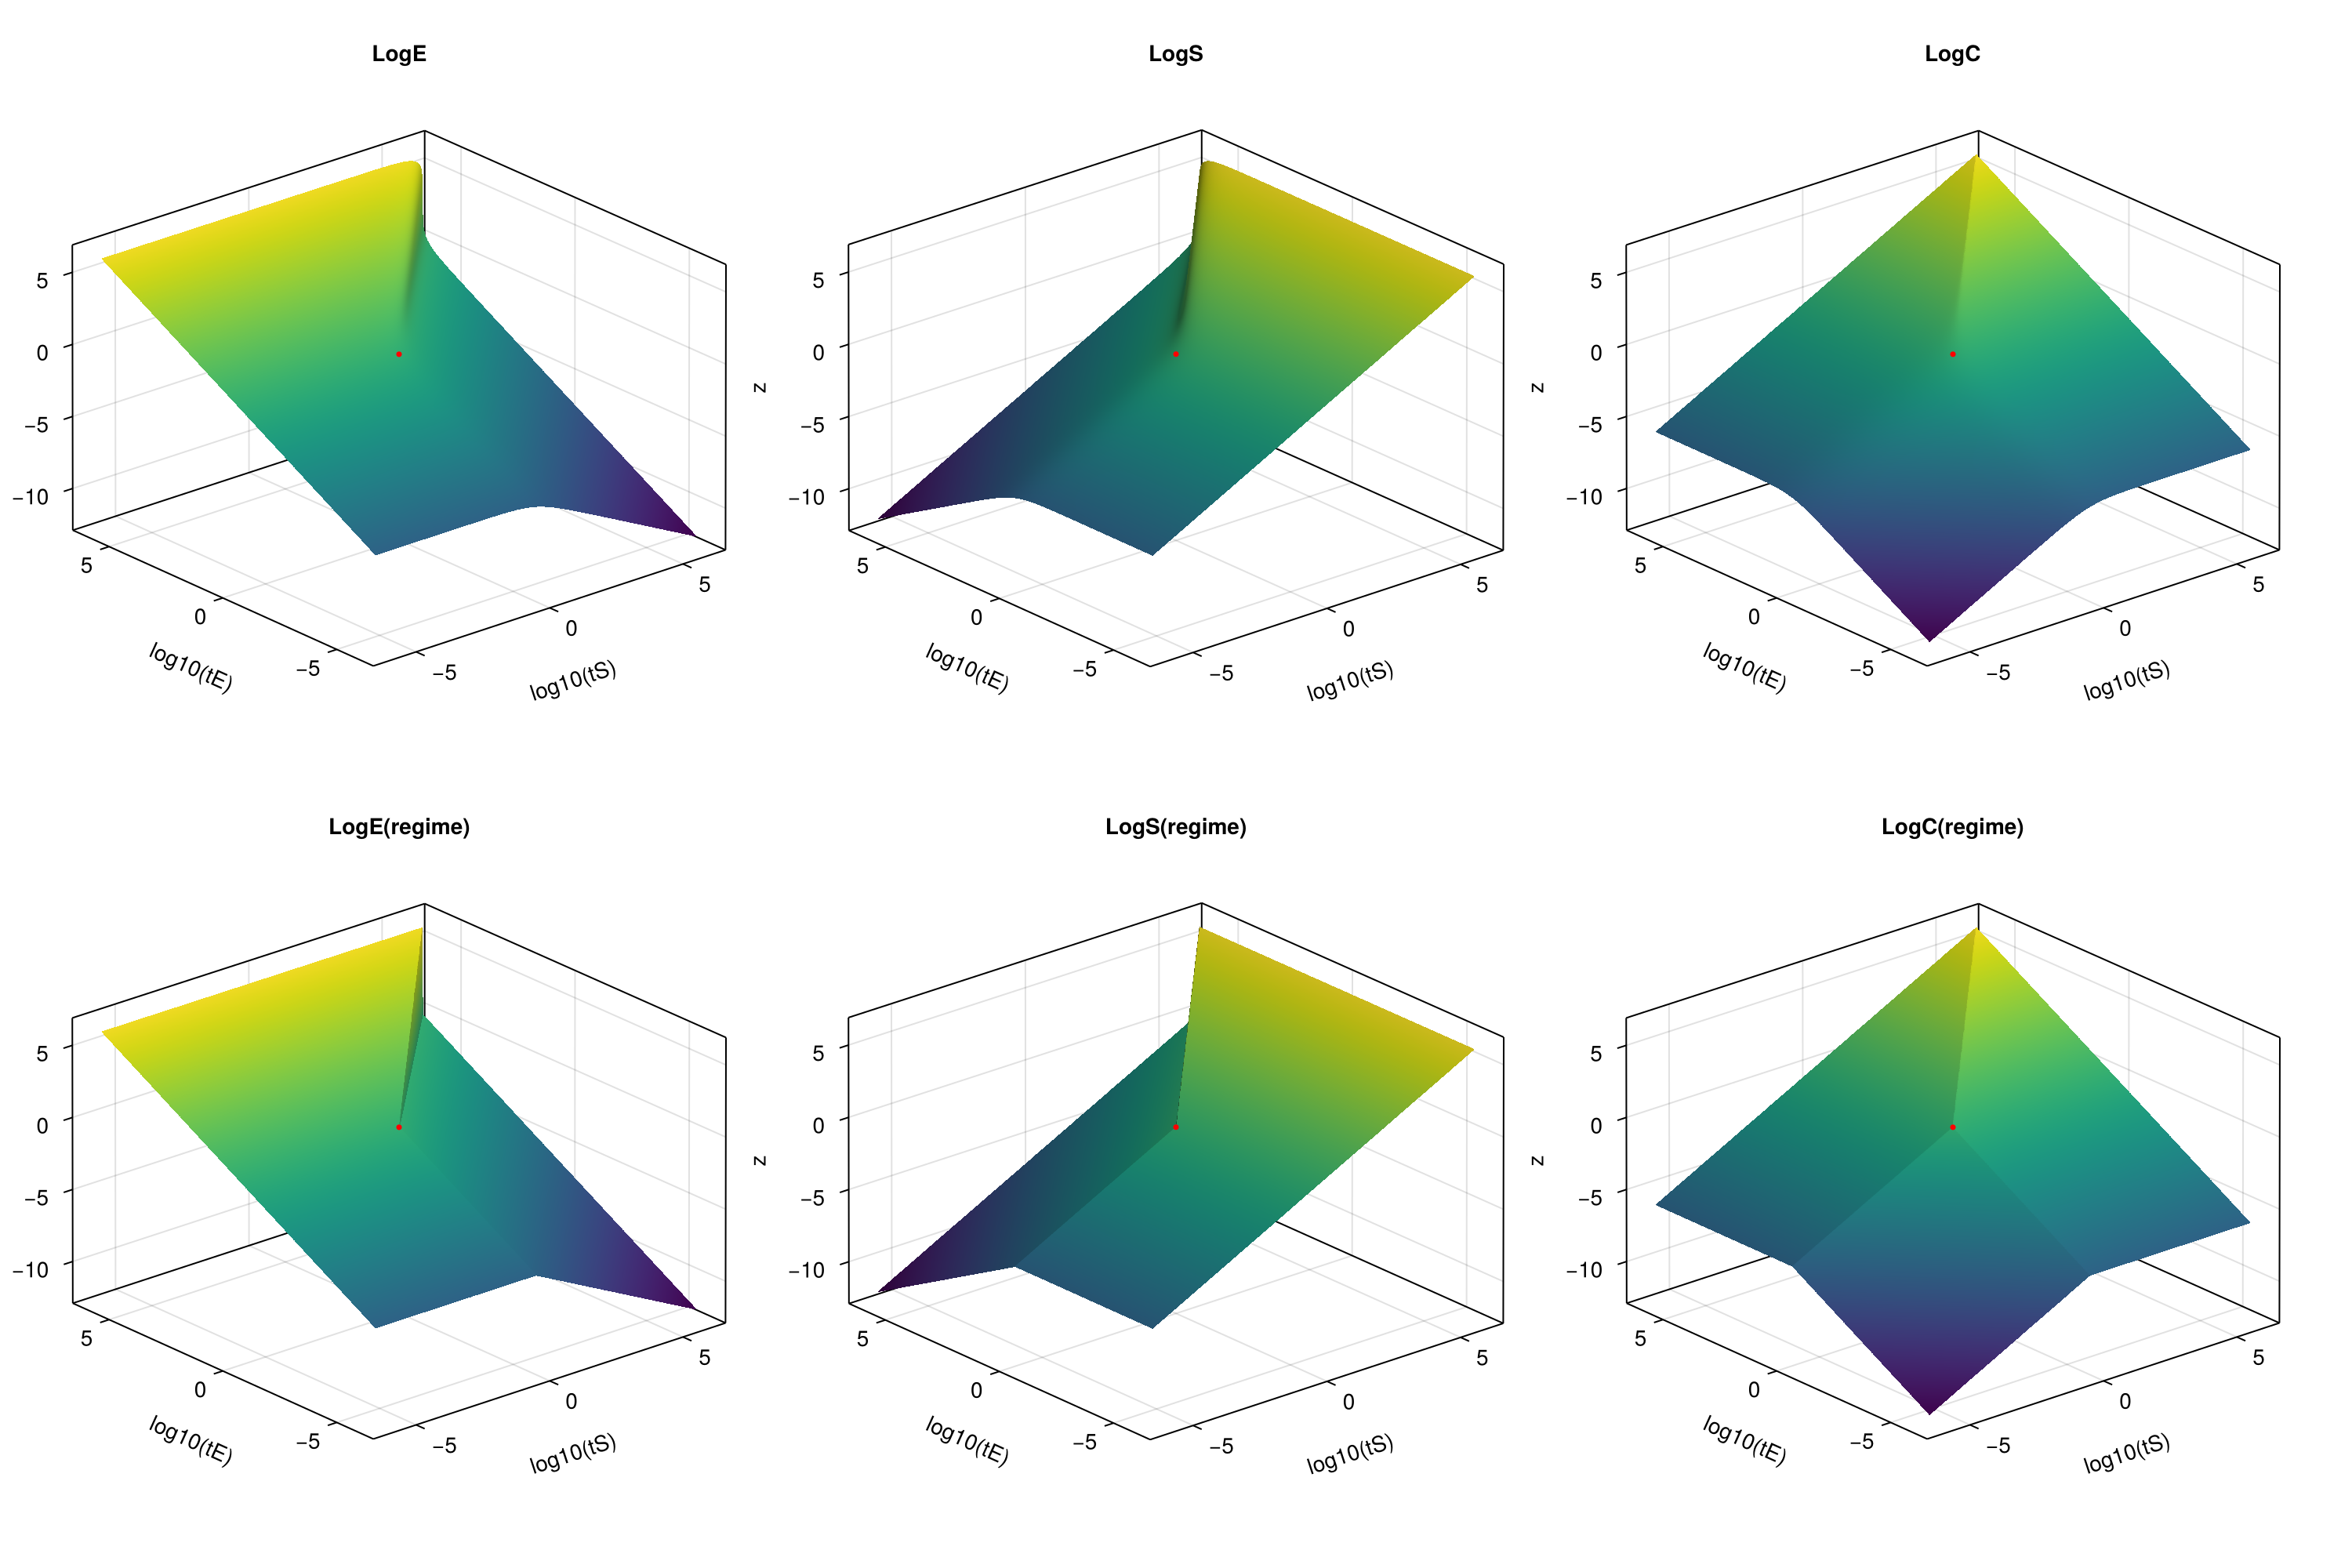

CairoMakie.Screen{IMAGE}


In [85]:
#3D plot (is slow for CarioMakie)
# using GLMakie
f = Figure(size=(1500,1000))

begin
    p1 = Axis3(f[1, 1])
    p2 = Axis3(f[1, 2])
    p3 = Axis3(f[1, 3])
    # p4 = Axis(f[2, 2])
    crange = (-12,6)

    p1.title = "LogE"
    a1 = surface!(p1, logS_rg, logE_rg, logx .|> x->x[1], colormap=:viridis,colorrange=crange)
    # contour!(p1, logE_rg, logS_rg, bnds_nonasym_x,color = :black)

    p2.title = "LogS"
    surface!(p2, logS_rg, logE_rg, logx .|> x->x[2], colormap=:viridis,colorrange=crange)

    p3.title = "LogC"
    surface!(p3, logS_rg, logE_rg, logx .|> x->x[3], colormap=:viridis,colorrange=crange)
    # contour!(p3, logE_rg, logS_rg, bnds_nonasym_x, color = :black)
    # lines!(p3, [-6,6], [-6,6], color=:white, linestyle=:dash)

    for p in [p1, p2, p3, ]
        # Add the red dot
        scatter!(p, [logK], [logK],[0], marker=:circle, markersize=5, color=:red)
        # Set the axis labels (modern syntax)
        p.xlabel = "log10(tS)"
        p.ylabel = "log10(tE)"
    end
end


# Colorbar(f[:,end+1], a1)


begin 
    p1 = Axis3(f[2, 1])
    p2 = Axis3(f[2, 2])
    p3 = Axis3(f[2, 3])
    # p4 = Axis(f[2, 2])
    crange = (-12,6)

    p1.title = "LogE(regime)"
    a1 = surface!(p1, logS_rg, logE_rg, logx_rgm .|> x->x[1], colormap=:viridis,colorrange=crange)
    # contour!(p1, logE_rg, logS_rg, bnds_nonasym_x,color = :black)

    p2.title = "LogS(regime)"
    surface!(p2, logS_rg, logE_rg, logx_rgm .|> x->x[2], colormap=:viridis,colorrange=crange)
    p3.title = "LogC(regime)"
    surface!(p3, logS_rg, logE_rg, logx_rgm .|> x->x[3], colormap=:viridis,colorrange=crange)
    # contour!(p3, logE_rg, logS_rg, bnds_nonasym_x, color = :black)
    # lines!(p3, [-6,6], [-6,6], color=:white, linestyle=:dash)

    for p in [p1, p2, p3, ]
        # Add the red dot
        scatter!(p, [logK], [logK],[0], marker=:circle, markersize=5, color=:red)
        # Set the axis labels (modern syntax)
        p.xlabel = "log10(tS)"
        p.ylabel = "log10(tE)"
    end
end





display(f)